In [3]:
#%load_ext autotime

import scvelo as scv
import loompy
import scanpy
import igraph
import glob, os
import pandas as pd
import os
import re
import subprocess
from collections import Counter
import numpy as np
from shutil import rmtree
import os
import anndata
import scvi
import torch
from rich import print


import h5py
from shutil import copyfile


def copyFiles(files, to):
    for f in files:
        name = os.path.basename( f )
        print( f"copy {f} to {to}" )
        copyfile( f, os.path.join(to, name ) )
    print( "all copied" )

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

scvelo==0.3.3
loompy==3.0.8
scanpy==1.11.0
igraph==0.11.8
pandas==2.2.3
re==2.2.1
numpy==1.26.4
anndata==0.11.3
scvi==1.3.0
torch==2.6.0+cu124
h5py==3.13.0

In [5]:
raw = "WhatCaWeDoFromHere_raw.h5ad"
ofile = "Experiment3_celltypes.h5ad"
saved="Chatties_CellTypes_added.h5ad"

experiment = "exp3"

In [30]:
adata = anndata.read_h5ad( raw ) 
adata

AnnData object with n_obs × n_vars = 27864 × 20540
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'mapping.score'
    var: 'n_counts', 'n_cells'

time: 1.66 s (started: 2025-05-06 09:16:58 +02:00)


In [31]:
exp = {
    "PBS_BM": "exp1",
    "PBS_Spl": "exp1",
    "TM_Spl": "exp1",
    "BM_PBS": "exp2", 
    "BM_TM": "exp2",
    "Spleen_TM": "exp2",
    "PBS_CD45_Neg_gex": "exp3", 
    "TM_CD45_Neg_gex": "exp3", 
"PBS_CD45_Pos_gex": "exp3", 
     "TM_CD45_Pos_gex": "exp3", 
}


time: 356 µs (started: 2025-05-06 09:16:59 +02:00)


In [32]:
adata = adata[adata.obs.sname.isin( [k for k, v in exp.items() if v == experiment ] ) ]
adata

View of AnnData object with n_obs × n_vars = 3811 × 20540
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'mapping.score'
    var: 'n_counts', 'n_cells'

time: 6.1 ms (started: 2025-05-06 09:16:59 +02:00)


In [33]:
def write_stats_tables( adata, key_added,cn ="leiden" ):

    scanpy.tl.rank_genes_groups(
        adata, 
        groupby   = cn,
        key_added = key_added,
        method    = 'wilcoxon',
    )

    scanpy.pl.rank_genes_groups(adata, key = key_added, save= key_added+"_overview")

    diff_results = adata.uns[key_added]
    columns = ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
    try: 
        os.mkdir(f"{key_added}") 
    except OSError as error: 
        print(error)  

    for i in adata.obs[cn].unique():
        table = {}
        for j in columns:
            #print(f"Analyszing column {diff_results[j]} {i}")
            table[j] = pd.DataFrame(diff_results[j])[str(i)]
        table = pd.DataFrame(table).to_csv(f"{key_added}/{cn}_cluster_{i}.csv")

def testRP(x, RP):
    r= True
    if RP.match(x):
        r = False
    return (r)

def dropRP ( adata, drop = True ):
    """ remove all genes matching to /^R[pP][SsLl]/ """
    RP = re.compile('^R[pP][SsLl]')
    RPgenes = [ x  for x in adata.var.index if not testRP(x, RP)]
    print ( Counter(RPgenes) )
    if  len(RPgenes) > 0:
        adata.obs['RP[LS]sum'] = adata[:,RPgenes].X.sum(axis=1)
    else:
        adata.obs['RP[LS]sum'] = 0
    if drop and len(RPgenes) > 0:
        OK = [ testRP(x, RP) for x in adata.var.index ]
        print(Counter(OK))
        adata._inplace_subset_var( np.array(OK) )
    adata

def testMT(x, MT):
    r= True
    if MT.match(x):
        r = False
    return (r)

def dropMT (adata, drop = True ) :
    """ remove all genes matching to /^[Mm][Tt]-/ """
    MT = re.compile('^[Mm][Tt]-')
    MTgenes = [ x  for x in adata.var.index if not testMT(x, MT)]
    print ( Counter(MTgenes) )
    if len(MTgenes) > 0:
        adata.obs['MTsum'] = adata[:,MTgenes].X.sum(axis=1)
    else:
        adata.obs['MTsum'] = 0
    if drop and len(MTgenes) > 0:
        OK = [ testMT(x, MT) for x in adata.var.index ]
        adata._inplace_subset_var( np.array(OK) )

def scale_values(row):
    total_sum = sum(row)
    scaled_values = {key: value * 100 / total_sum for key, value in row.items()}
    return scaled_values

def testGene(x, MT, RP):
    r= True
    if MT.match(x) or RP.match(x):
        r = False
    return (r)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_umap_with_cluster_contours(
    adata,
    contour_group='louvain',
    subset_group='CellType',
    cells_selected='T_cells',
    cells_unselected='lightgray',
    fill_alpha=0.2,
    contour_alpha=0.8,
    contour_linewidth=1.5
):
    """
    Plots UMAP with cluster density contours and highlights a selected cell type.
    
    Parameters:
    - adata: AnnData object
    - contour_group: str, column in adata.obs used for contour grouping (e.g., 'louvain')
    - subset_group: str, column in adata.obs used for subset highlighting (e.g., 'CellType')
    - cells_selected: str, value in subset_group to highlight (e.g., 'T_cells')
    - cells_unselected: str, color for background cells
    - fill_alpha: float, alpha transparency for contour fill
    - contour_alpha: float, alpha transparency for contour edges
    - contour_linewidth: float, line width of contour edges
    """
    x = adata.obsm['X_umap'][:, 0]
    y = adata.obsm['X_umap'][:, 1]

    fig, ax = plt.subplots(figsize=(8,8))

    # Plot all cells in background color
    ax.scatter(x, y, s=5, color=cells_unselected, alpha=0.5)

    # Highlight selected cells
    mask_selected = adata.obs[subset_group] == cells_selected
    ax.scatter(x[mask_selected], y[mask_selected], s=10, color='red', label=cells_selected)

    # Get cluster information
    clusters = adata.obs[contour_group].cat.categories
    cluster_colors = adata.uns[f'{contour_group}_colors']

    # Draw filled contours for each cluster
    for cluster, color in zip(clusters, cluster_colors):
        idx = adata.obs[contour_group] == cluster
        if np.sum(idx) < 5:
            continue  # skip tiny clusters
        
        sns.kdeplot(
            data={'x': x[idx], 'y': y[idx]},
            x='x',
            y='y',
            bw_adjust=0.5,         # thighter line around the cluster
            levels=[0.01],         # only outer contour
            fill=False,
            thresh=0.01,
            #alpha=fill_alpha,
            color=color,
            linewidths=contour_linewidth,
            ax=ax
        )
        #sns.kdeplot(
        #    data={'x': x[idx], 'y': y[idx]},
        #    x='x',
        #    y='y',
        #    levels=[0.01],         # outline again for sharp edge
        #    fill=False,
        #    color=color,
        #    alpha=contour_alpha,
        #    linewidths=contour_linewidth,
        #    ax=ax
        #)

    plt.legend()
    plt.title(f"Highlight: {cells_selected} with {contour_group} contours")
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return fig, ax

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


time: 2.7 ms (started: 2025-05-06 09:17:00 +02:00)


# After Teams Meating 12 the March 2025

Micke asked to build a UMAP from only the PBS_BM and instead of adding the other data before UMAP creation to map the other two data - but mainly the TM_Spleen - to that UMAP and check which normally existing red cells would be and which are missing.

In [34]:
Counter(adata.obs['sname'])

Counter({'TM_CD45_Neg_gex': 2309, 'PBS_CD45_Neg_gex': 1502})

time: 5.72 ms (started: 2025-05-06 09:17:00 +02:00)


In [35]:
def preprocess( adata, drop_ribosomal=True, drop_mitochondrial=True, minUMI=1000, minFeatures=100, n_highly_significant = 300, dimensions = 2, resolution = 1 ) :
    ## QC calculations
    scanpy.pp.calculate_qc_metrics( adata, inplace=True)
    ## Filter out common repeat expressed sequences
    MT = re.compile('^[Mm][Tt]-')
    RP = re.compile('^R[pP][SsLl]')
    genes = [ x  for x in adata.var.index if testGene(x, MT, RP)]
    adata.obs['geneSum'] = adata[:,genes].X.sum(axis=1)
    dropRP( adata, drop_ribosomal )
    dropMT( adata, drop_mitochondrial )
    ## filter cells ( >1000 nUMI per cell and > 100 features per cell)
    adata = adata[ adata.obs['geneSum'] > minUMI]
    scanpy.pp.filter_cells(adata, min_genes=minFeatures)
    ## normalze
    scanpy.pp.downsample_counts(adata, counts_per_cell=minUMI )
    ## drop now empty genes
    scanpy.pp.filter_genes(adata, min_counts=1 )
    ## create UMP
    scv.pp.log1p(adata)
    scanpy.pp.highly_variable_genes(adata, n_top_genes=n_highly_significant )
    scanpy.pp.neighbors(adata)
    scanpy.tl.umap(adata,n_components= dimensions)
    ## calculate leden clausters
    scanpy.tl.leiden( adata, resolution = resolution )
    return ( adata )

time: 3.28 ms (started: 2025-05-06 09:17:00 +02:00)


In [36]:
adata = preprocess( adata )
adata

Counter({
    'Rpl7': 1,
    'Rpl31': 1,
    'Rpl37a': 1,
    'Rps6kc1': 1,
    'Rpl7a': 1,
    'Rpl12': 1,
    'Rpl35': 1,
    'Rps21': 1,
    'Rpl22l1': 1,
    'Rps3a1': 1,
    'Rps27': 1,
    'Rpl34': 1,
    'Rps20': 1,
    'Rps6': 1,
    'Rps8': 1,
    'Rps6ka1': 1,
    'Rpl11': 1,
    'Rpl22': 1,
    'Rpl9': 1,
    'Rpl5': 1,
    'Rplp0': 1,
    'Rpl6': 1,
    'Rpl21': 1,
    'Rpl32': 1,
    'Rps9': 1,
    'Rpl28': 1,
    'Rps5': 1,
    'Rps19': 1,
    'Rps16': 1,
    'Rps11': 1,
    'Rpl13a': 1,
    'Rpl18': 1,
    'Rps17': 1,
    'Rps3': 1,
    'Rpl27a': 1,
    'Rps13': 1,
    'Rps15a': 1,
    'Rplp2': 1,
    'Rpl18a': 1,
    'Rpl13': 1,
    'Rps25': 1,
    'Rpl10-ps3': 1,
    'Rplp1': 1,
    'Rpl4': 1,
    'Rps27l': 1,
    'Rpl29': 1,
    'Rps27rt': 1,
    'Rpsa': 1,
    'Rpl14': 1,
    'Rps12': 1,
    'Rps15': 1,
    'Rpl41': 1,
    'Rps26': 1,
    'Rps27a': 1,
    'Rpl26': 1,
    'Rpl23a': 1,
    'Rpl9-ps1': 1,
    'Rps6kb1': 1,
    'Rpl23': 1,
    'Rpl19': 1,
    'Rpl27': 1,
    'Rpl38': 1,
    'Rps7': 1,
    'Rps29': 1,
    'Rpl36al': 1,
    'Rps6kl1': 1,
    'Rps6ka5': 1,
    'Rps23': 1,
    'Rpl15': 1,
    'Rps24': 1,
    'Rpl36a-ps1': 1,
    'Rpl37': 1,
    'Rpl30': 1,
    'Rpl8': 1,
    'Rpl3': 1,
    'Rps19bp1': 1,
    'Rpl39l': 1,
    'Rpl35a': 1,
    'Rpl24': 1,
    'Rps6ka2': 1,
    'Rps2': 1,
    'Rpl3l': 1,
    'Rps10': 1,
    'Rpl10a': 1,
    'Rps28': 1,
    'Rps18': 1,
    'Rpl7l1': 1,
    'Rpl36': 1,
    'Rps14': 1,
    'Rpl17': 1,
    'Rps6kb2': 1,
    'Rps6ka4': 1,
    'Rpl9-ps6': 1,
    'Rpl39': 1,
    'Rpl10': 1,
    'Rps4x': 1,
    'Rps6ka6': 1,
    'Rpl36a': 1,
    'Rps6ka3': 1
})

Counter({True: 20441, False: 99})

Counter({
    'mt-Nd1': 1,
    'mt-Nd2': 1,
    'mt-Co1': 1,
    'mt-Co2': 1,
    'mt-Atp8': 1,
    'mt-Atp6': 1,
    'mt-Co3': 1,
    'mt-Nd3': 1,
    'mt-Nd4l': 1,
    'mt-Nd4': 1,
    'mt-Nd5': 1,
    'mt-Nd6': 1,
    'mt-Cytb': 1
})

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 3712 × 17929
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'mapping.score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geneSum', 'RP[LS]sum', 'MTsum', 'leiden'
    var: 'n_counts', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

time: 23.6 s (started: 2025-05-06 09:17:00 +02:00)


saving figure to file ./figures/scvelo__exp3_sname.svg


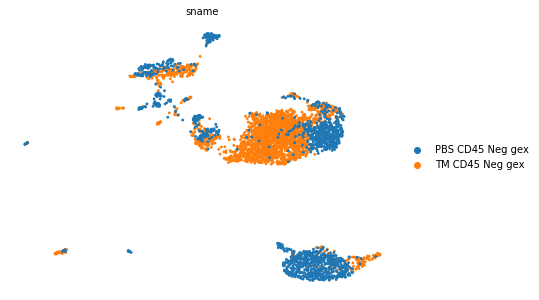

saving figure to file ./figures/scvelo__exp3_leiden.svg


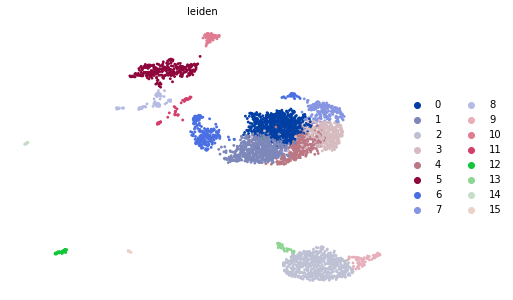

saving figure to file ./figures/scvelo__exp3_predicted.celltype.l2.svg


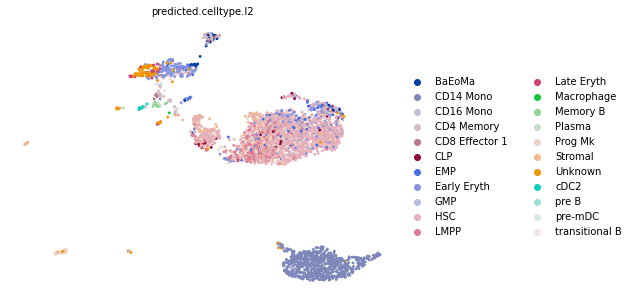

time: 2.86 s (started: 2025-05-06 09:17:23 +02:00)


In [37]:
scv.pl.scatter(adata, color=[ 'sname'], figsize =(7,5), legend_loc='right margin', save=f"_{experiment}_sname.svg")
scv.pl.scatter(adata, color=[ 'leiden'], figsize =(7,5), legend_loc='right margin', save=f"_{experiment}_leiden.svg")
scv.pl.scatter(adata, color=[ 'predicted.celltype.l2'], figsize =(7,5), legend_loc='right margin', save=f"_{experiment}_predicted.celltype.l2.svg")


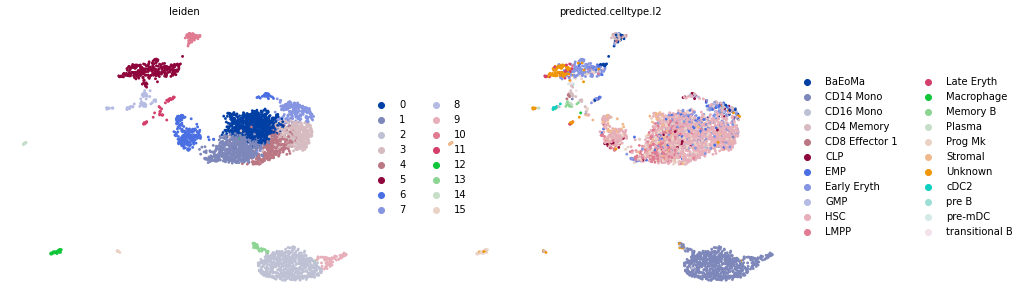

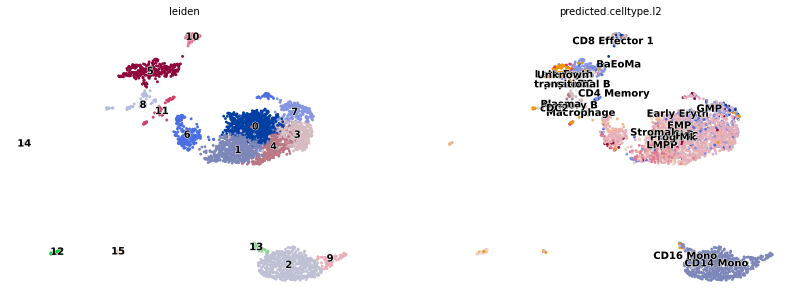

time: 1.14 s (started: 2025-05-06 09:17:26 +02:00)


In [38]:
scv.pl.scatter(adata, color=[ 'leiden', 'predicted.celltype.l2'], figsize =(7,5), legend_loc='right margin')
scv.pl.scatter(adata, color=[ 'leiden', 'predicted.celltype.l2'], figsize =(7,5), legend_loc='on data')

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_CD14 Mono.svg


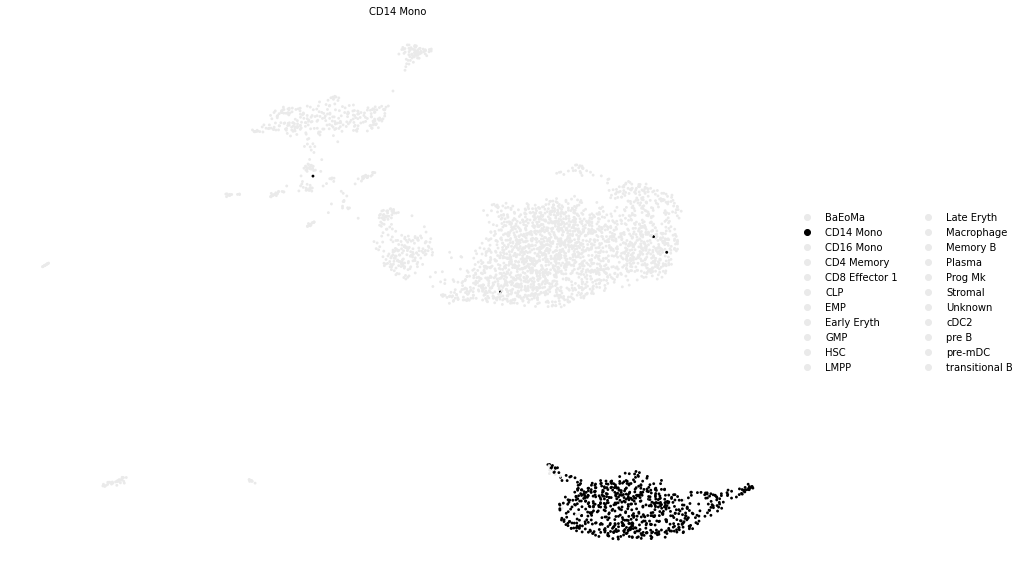

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_HSC.svg


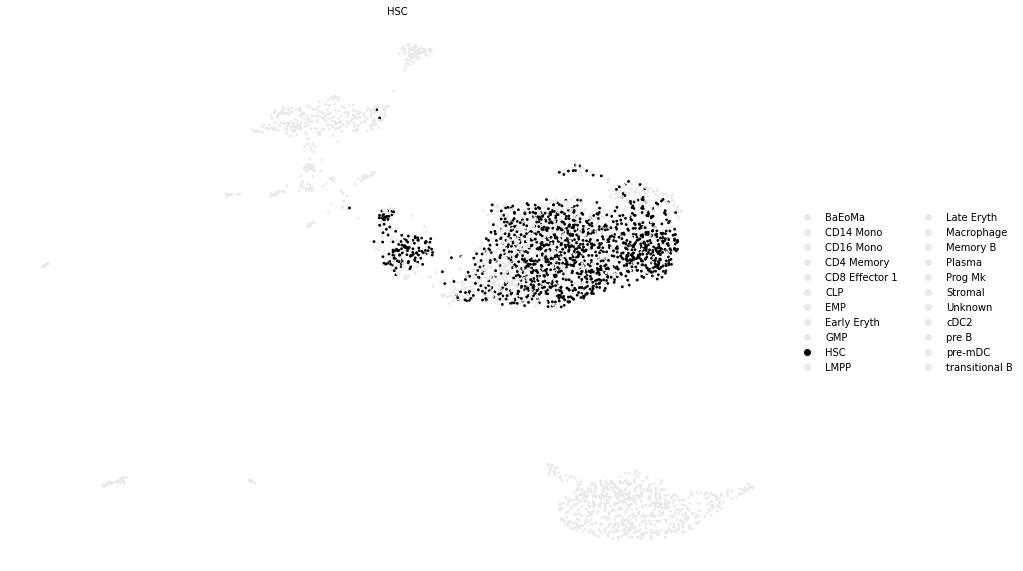

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Prog Mk.svg


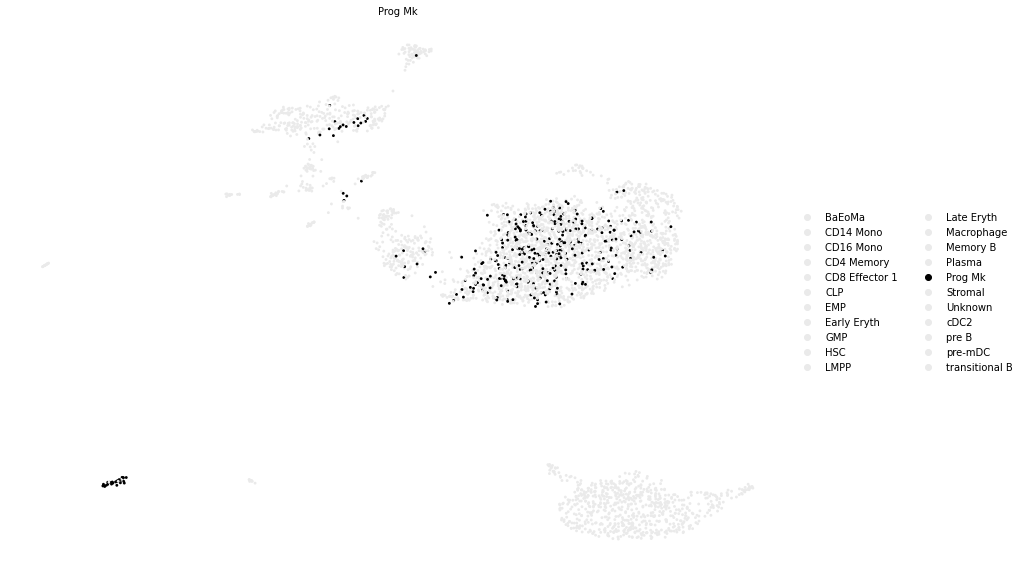

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Early Eryth.svg


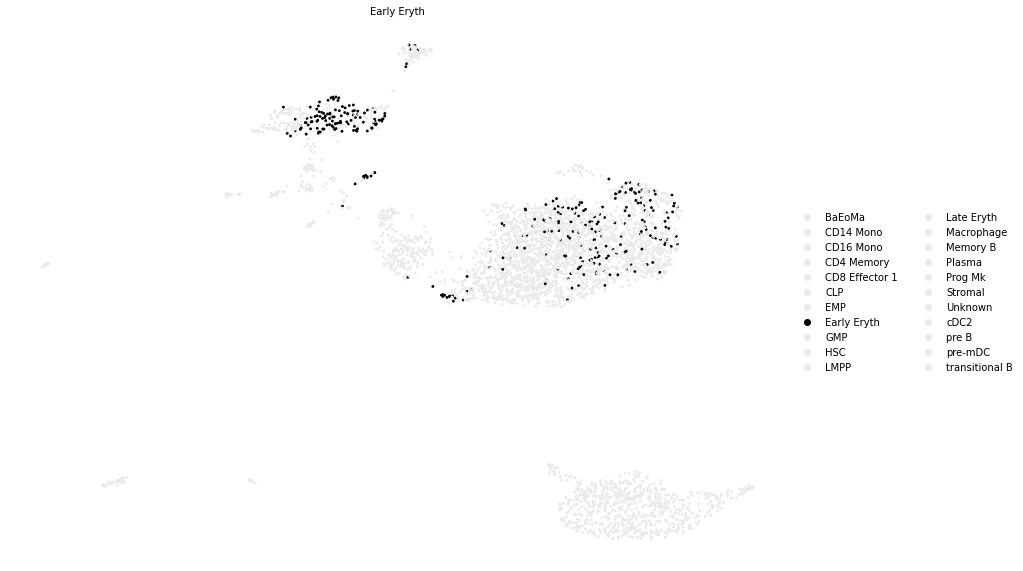

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Stromal.svg


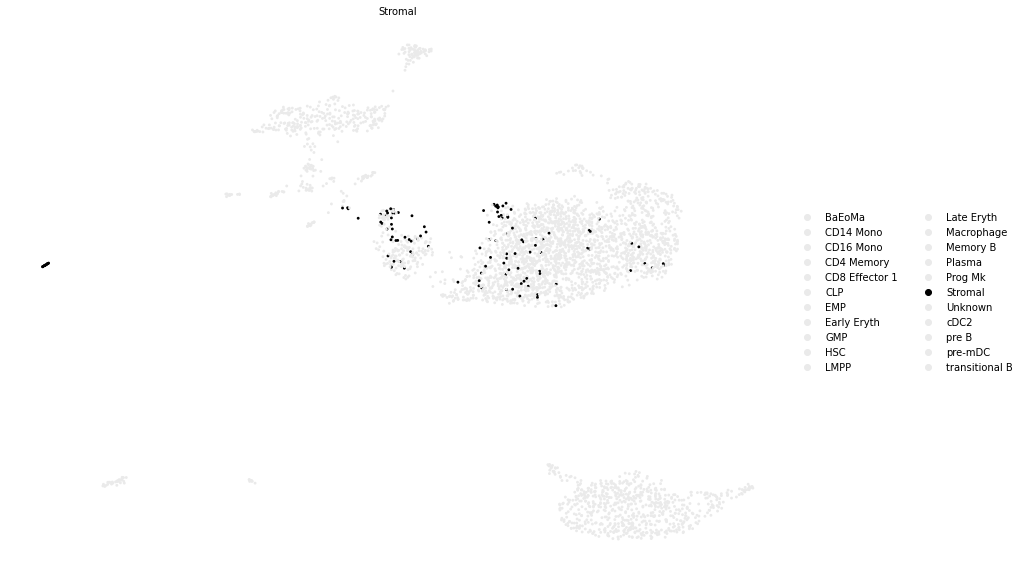

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_EMP.svg


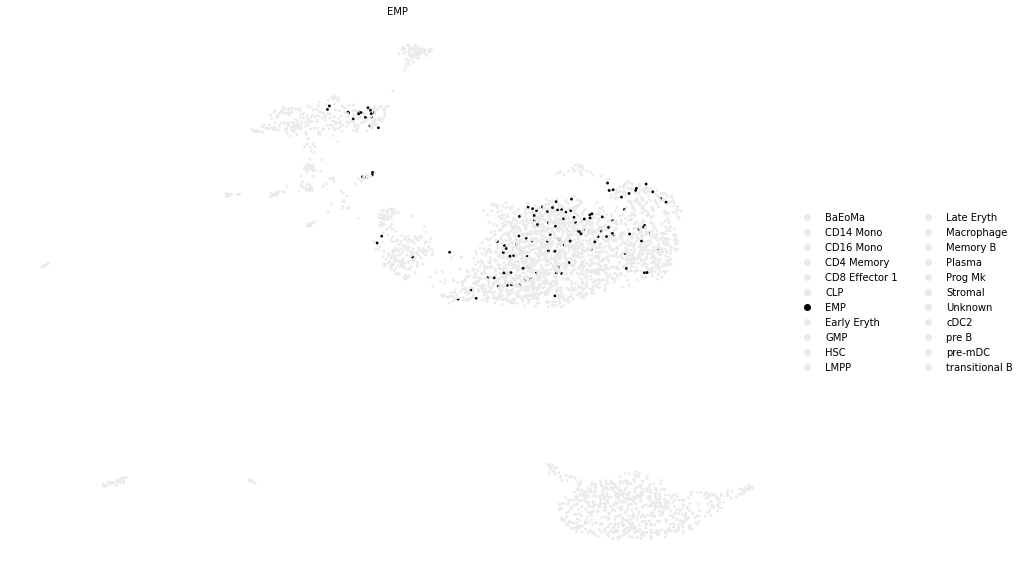

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_LMPP.svg


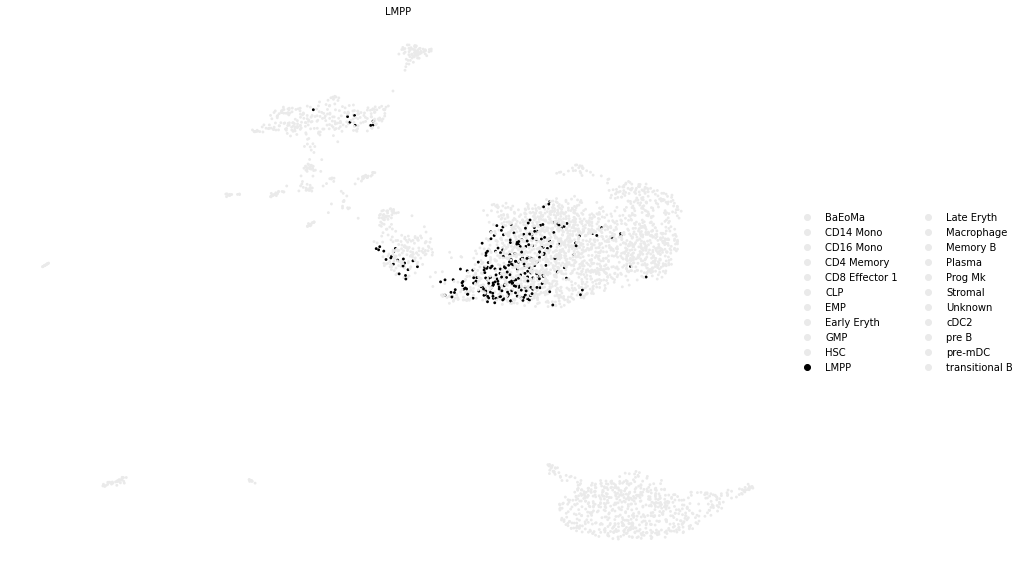

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Memory B.svg


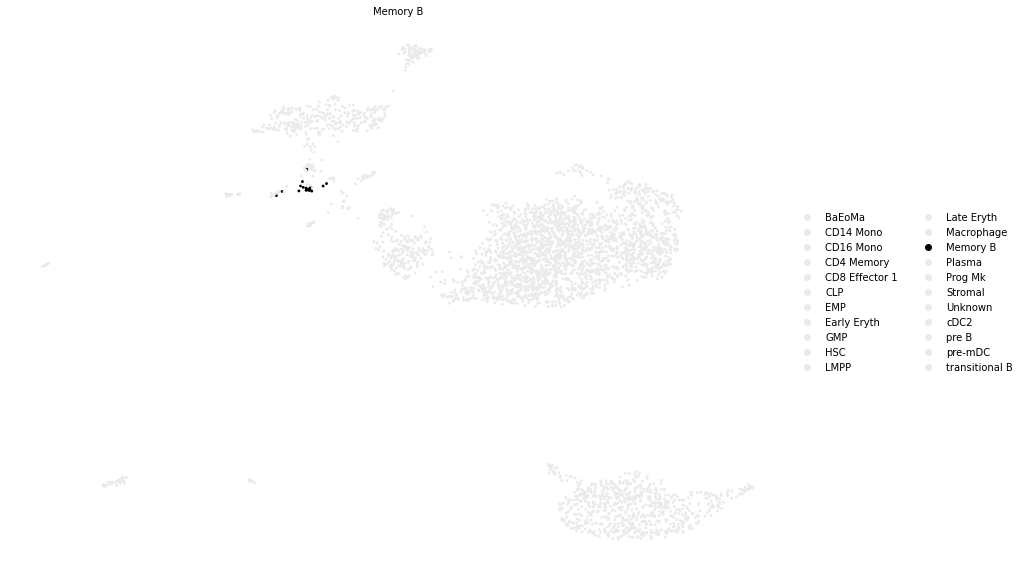

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_CLP.svg


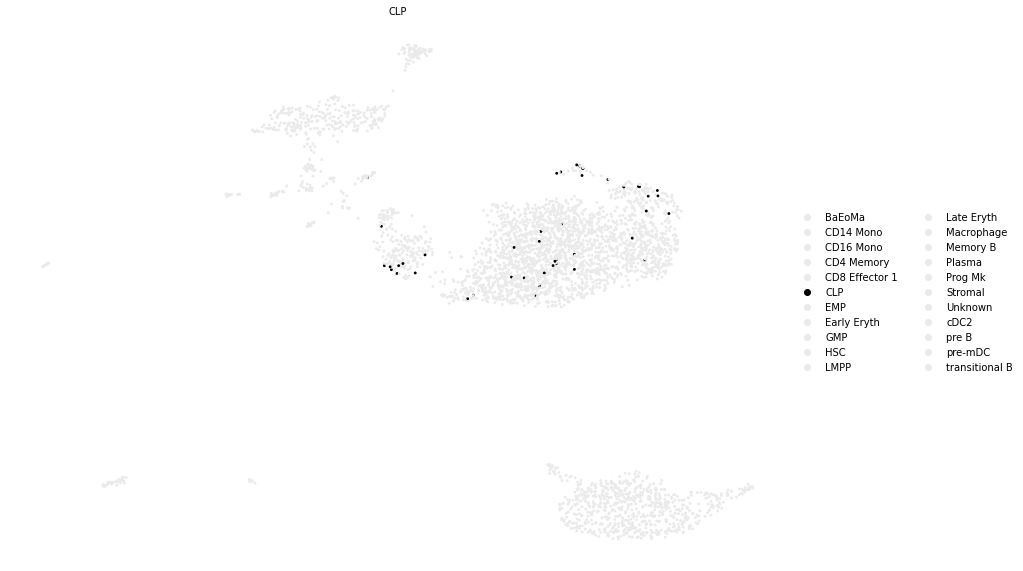

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_BaEoMa.svg


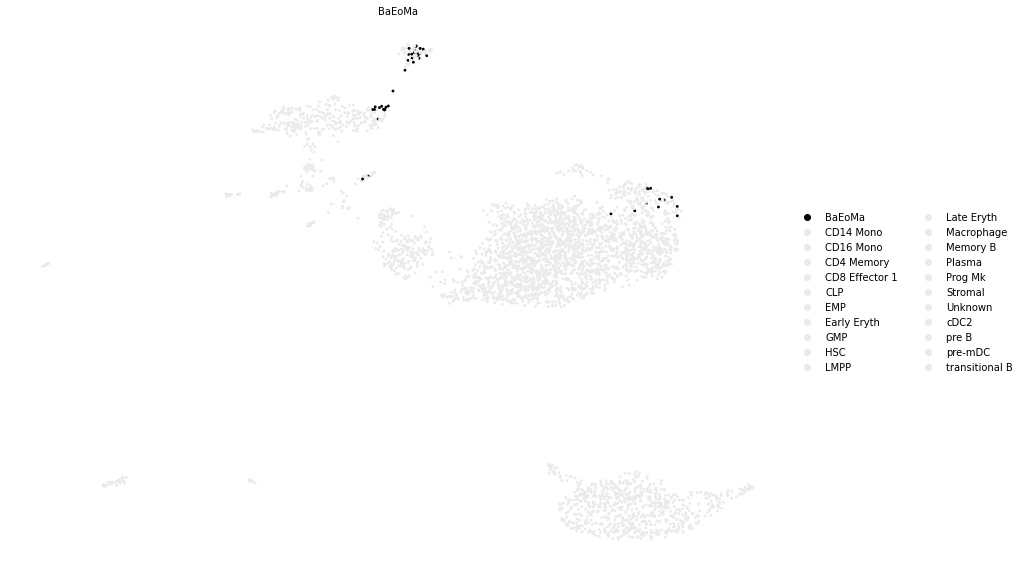

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Late Eryth.svg


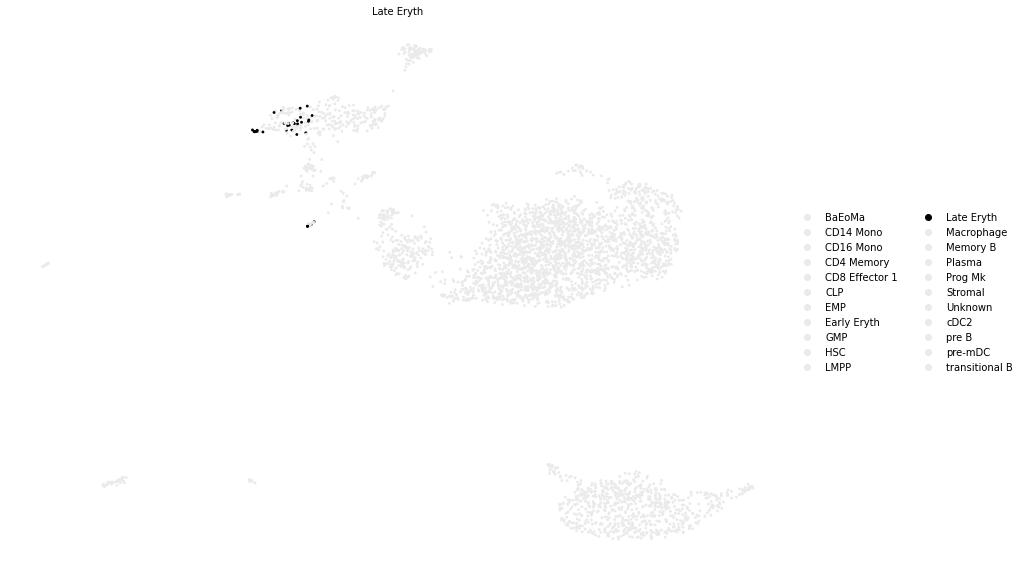

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Plasma.svg


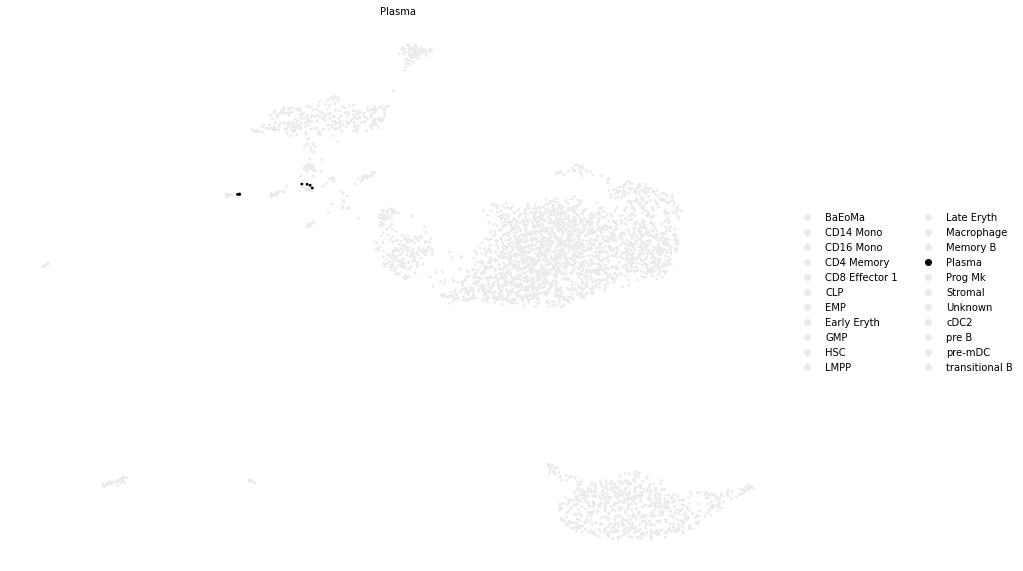

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_pre B.svg


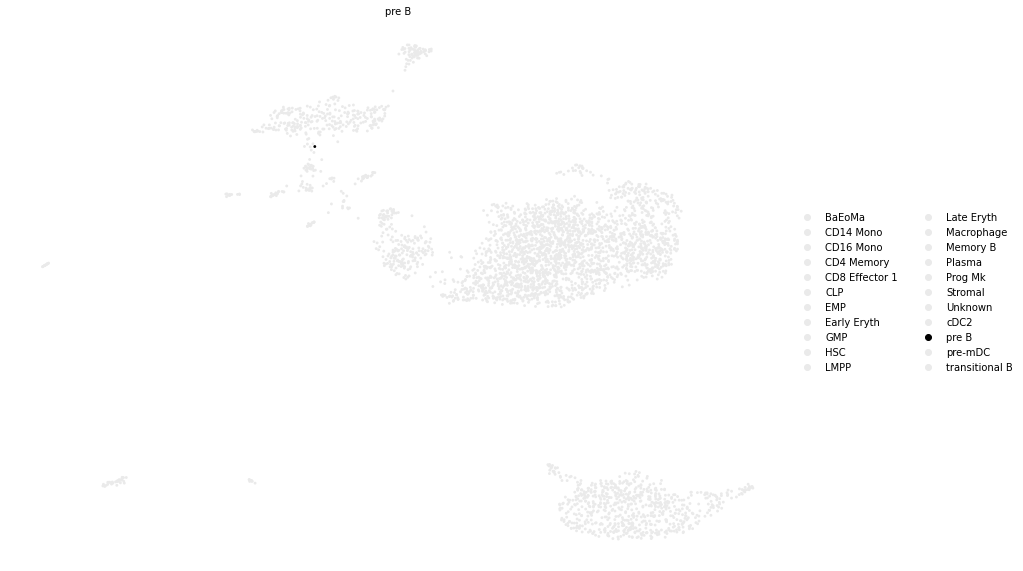

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_GMP.svg


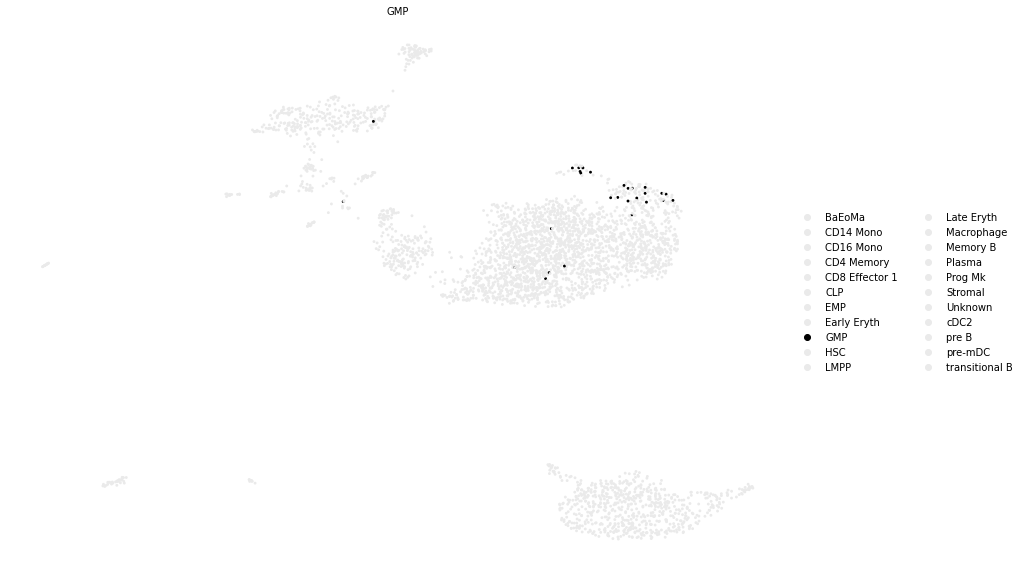

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_cDC2.svg


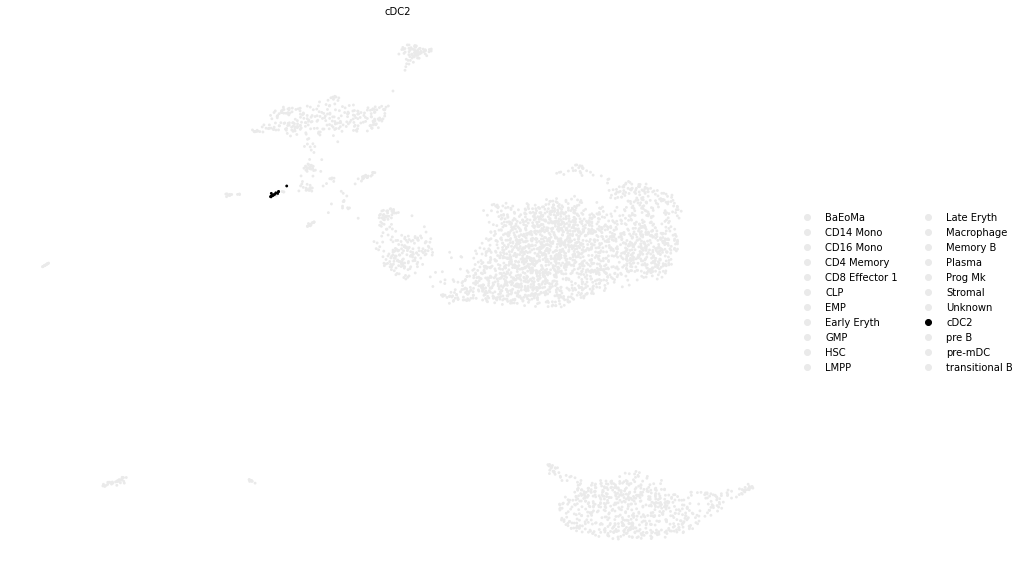

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Unknown.svg


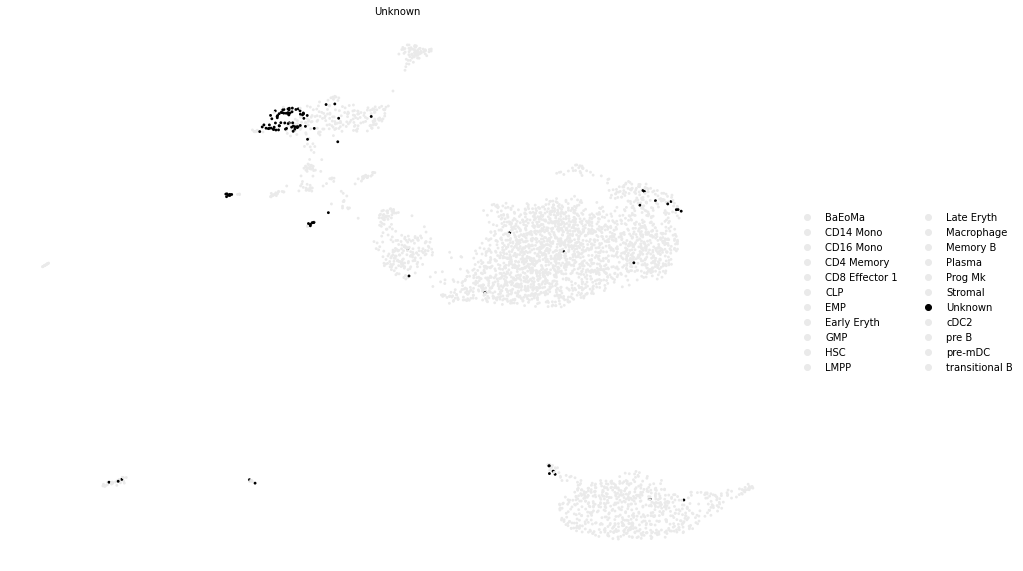

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_CD4 Memory.svg


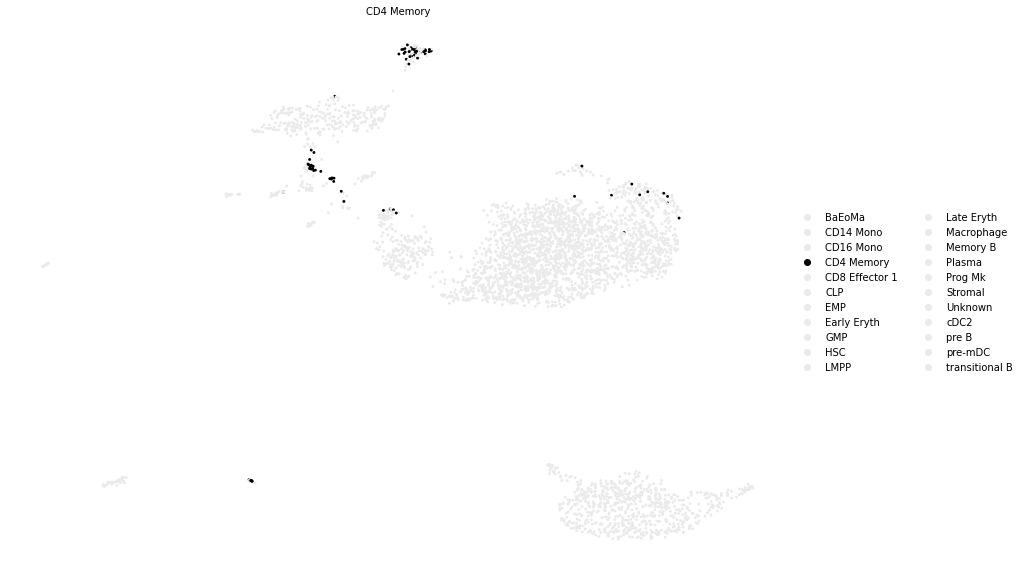

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_transitional B.svg


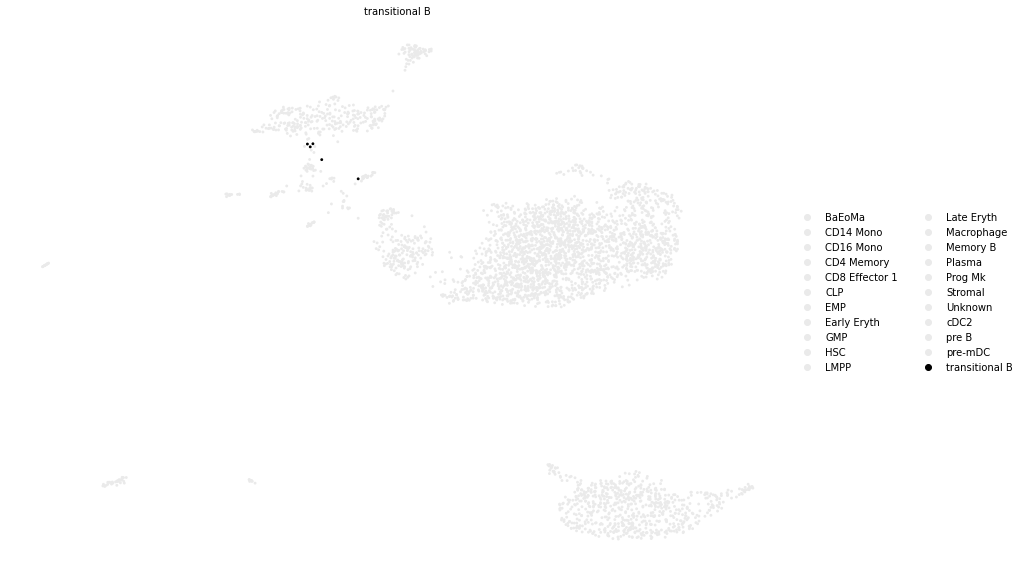

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_CD8 Effector_1.svg


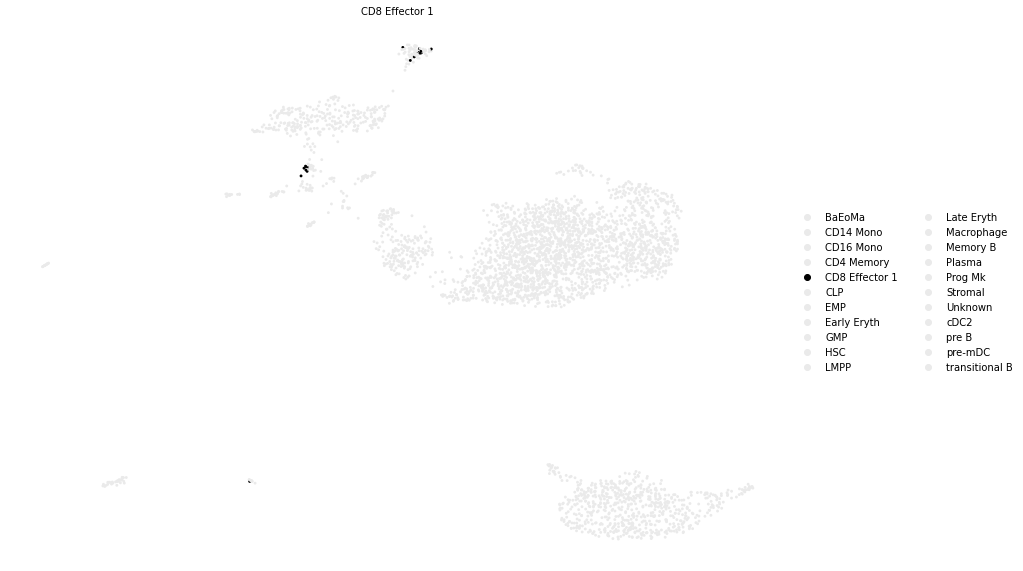

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_Macrophage.svg


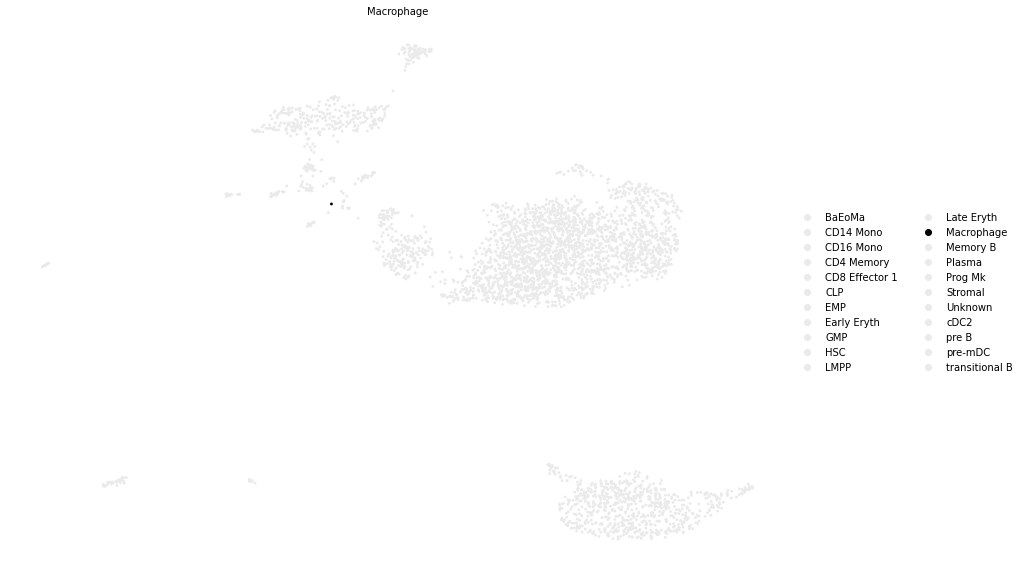

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_CD16 Mono.svg


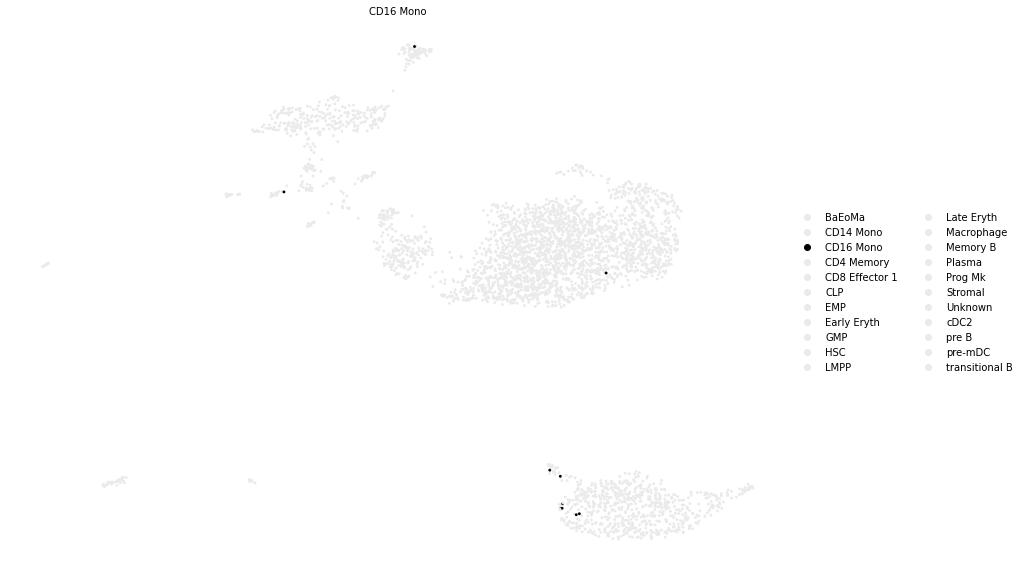

saving figure to file ./figures/scvelo_exp3_classic_predicted_celltype_l2_pre-mDC.svg


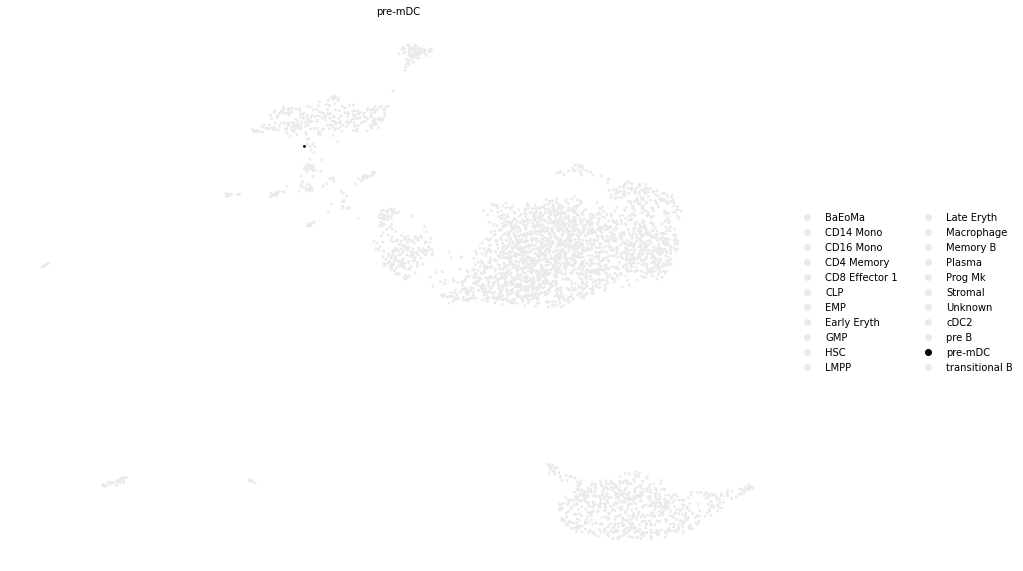

time: 20.8 s (started: 2025-05-06 09:17:27 +02:00)


In [39]:
# Get unique groups from the data
unique_groups = adata.obs['predicted.celltype.l2'].unique()

for celltype in unique_groups:
    # Create a palette where all groups are gray, except the target group which is black
    palette = {group: '#EAEAEA' for group in unique_groups}
    palette[celltype] = 'black'  # Set the target group to black

    # Plot with the custom palette
    scv.pl.scatter(adata, color=[ 'predicted.celltype.l2'], figsize =(14,10), 
                   legend_loc='right margin', palette=palette, title = celltype, save=f"{experiment}_classic_predicted_celltype_l2_{celltype}.svg" )

In [40]:
?plot_umap_with_cluster_contours

time: 2.48 ms (started: 2025-05-06 09:17:48 +02:00)


Signature:
plot_umap_with_cluster_contours(
    adata,
    contour_group='louvain',
    subset_group='CellType',
    cells_selected='T_cells',
    cells_unselected='lightgray',
    fill_alpha=0.2,
    contour_alpha=0.8,
    contour_linewidth=1.5,
)
Docstring:
Plots UMAP with cluster density contours and highlights a selected cell type.

Parameters:
- adata: AnnData object
- contour_group: str, column in adata.obs used for contour grouping (e.g., 'louvain')
- subset_group: str, column in adata.obs used for subset highlighting (e.g., 'CellType')
- cells_selected: str, value in subset_group to highlight (e.g., 'T_cells')
- cells_unselected: str, color for background cells
- fill_alpha: float, alpha transparency for contour fill
- contour_alpha: float, alpha transparency for contour edges
- contour_linewidth: float, line width of contour edges
File:      /tmp/ipykernel_454456/1553796623.py
Type:      function

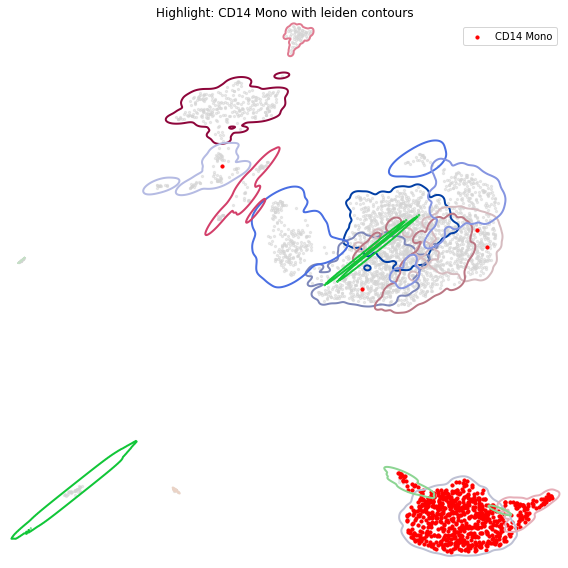

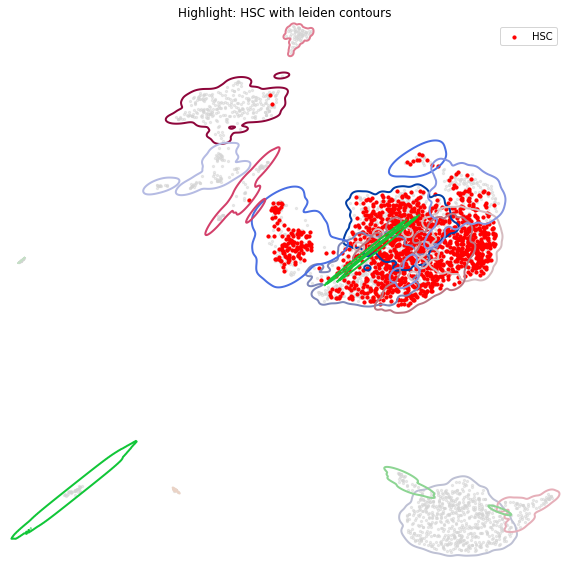

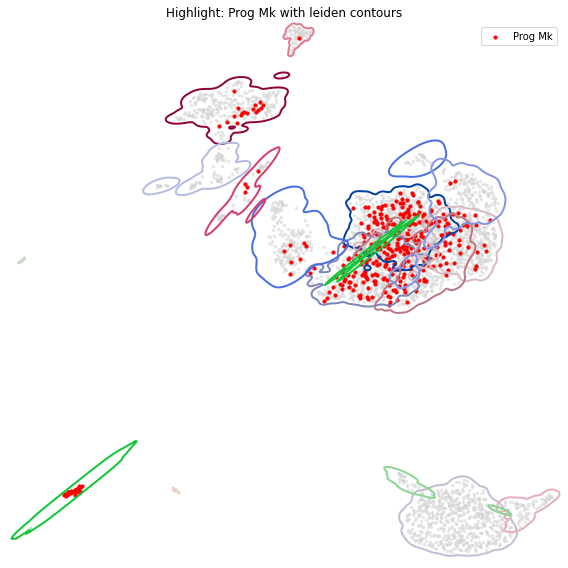

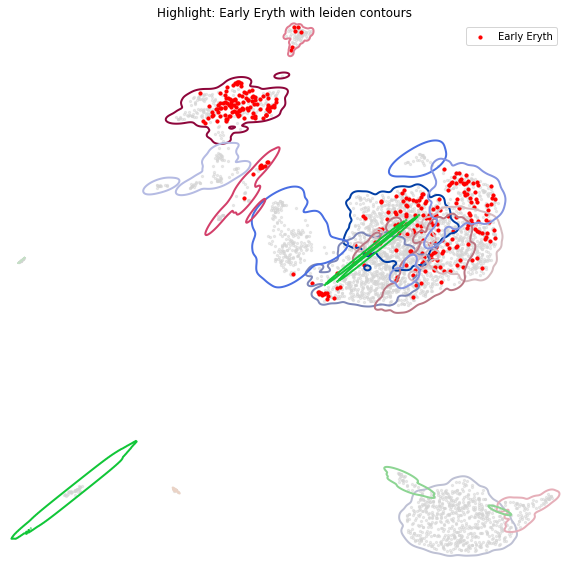

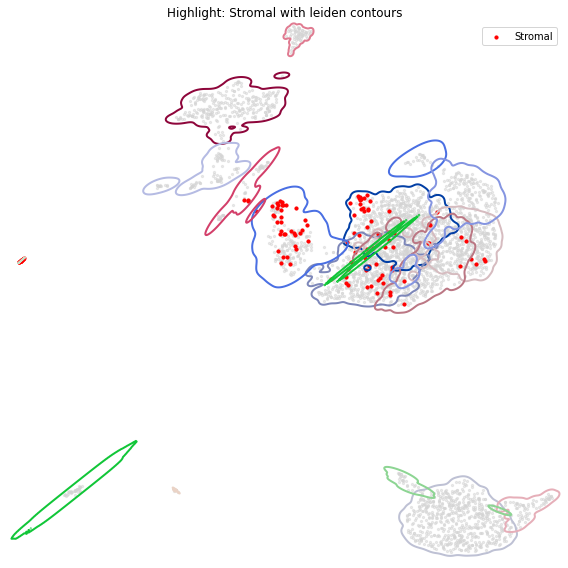

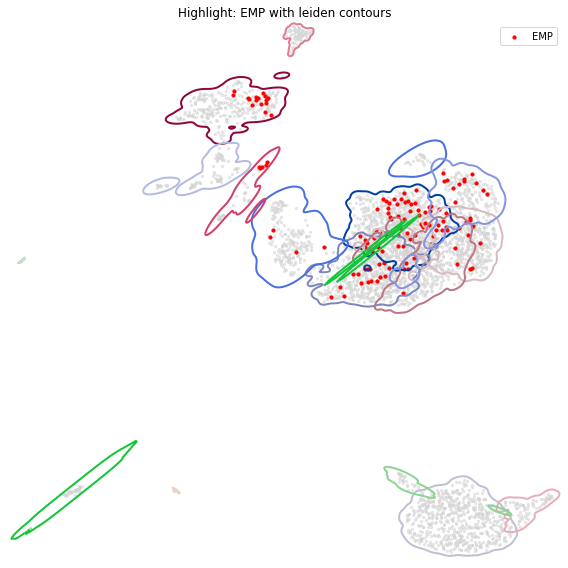

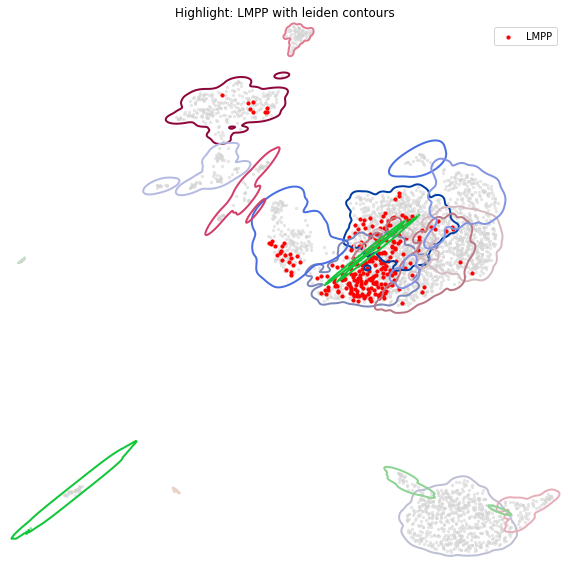

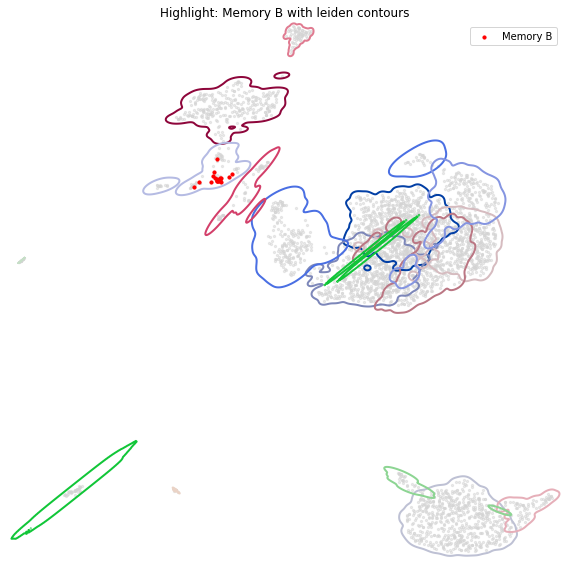

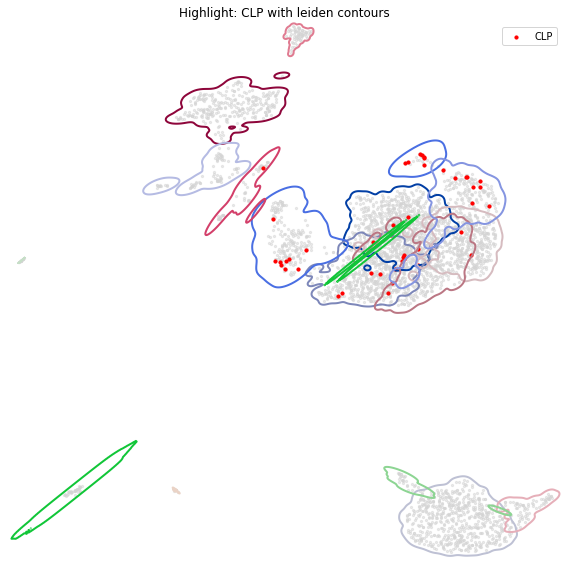

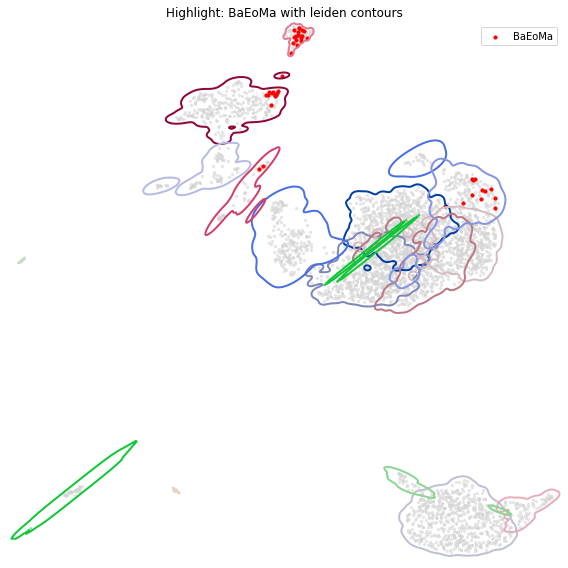

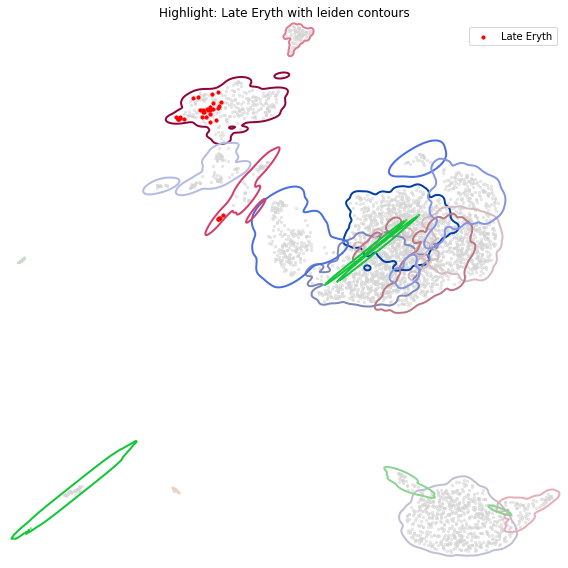

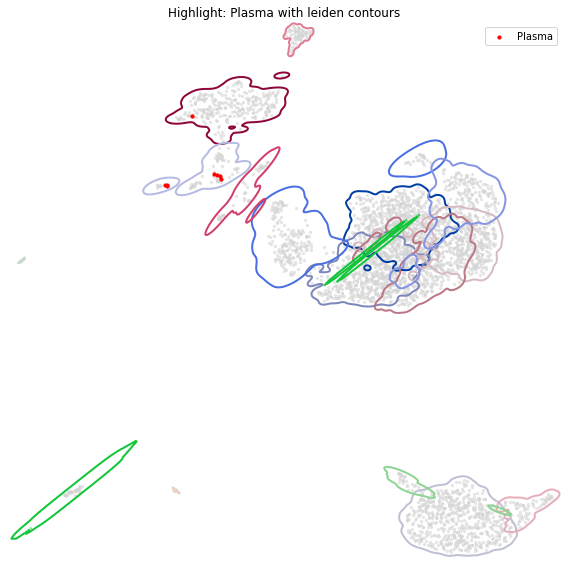

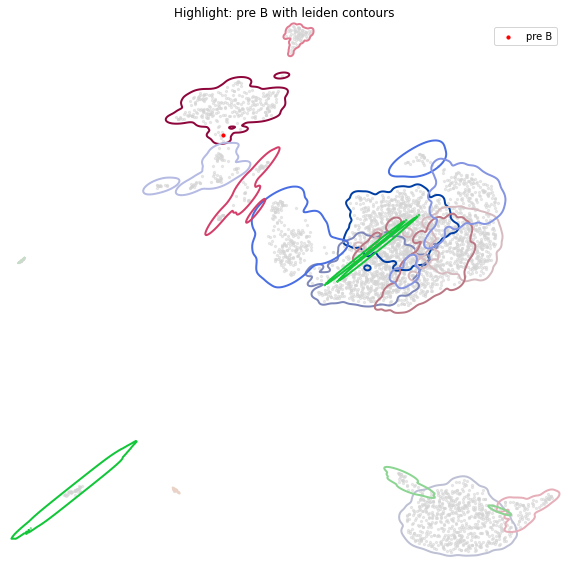

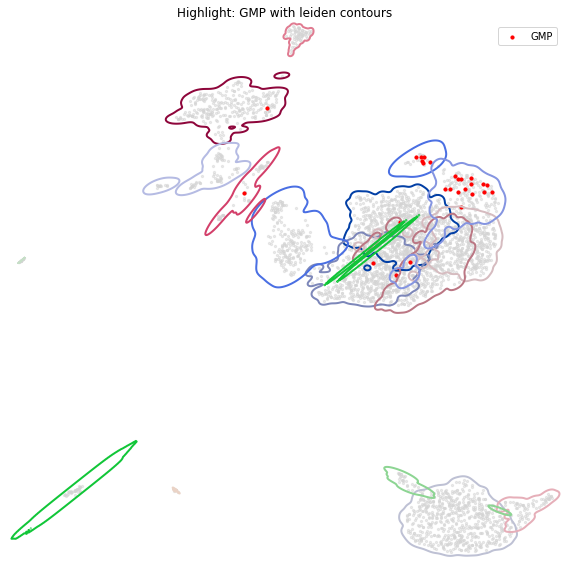

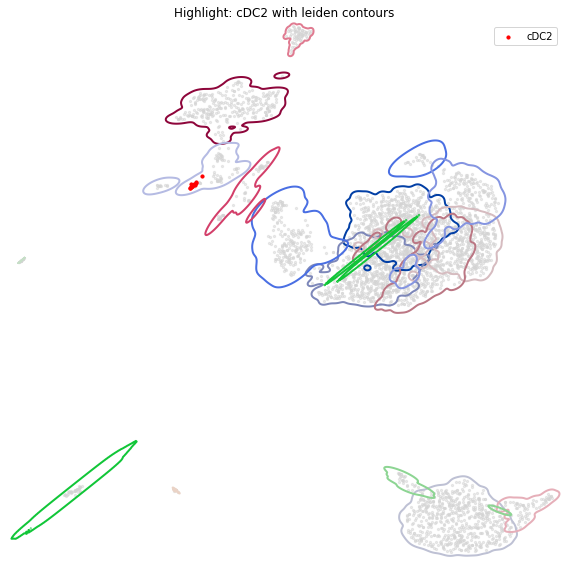

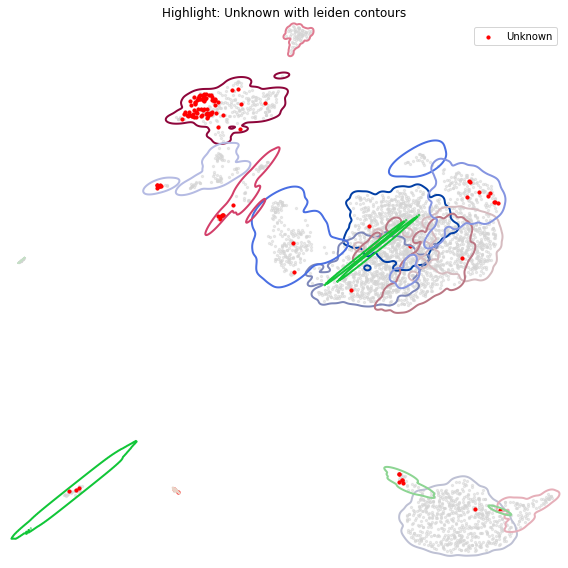

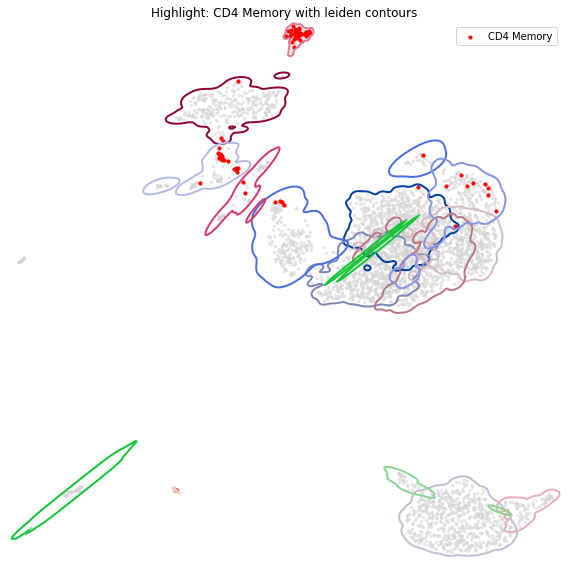

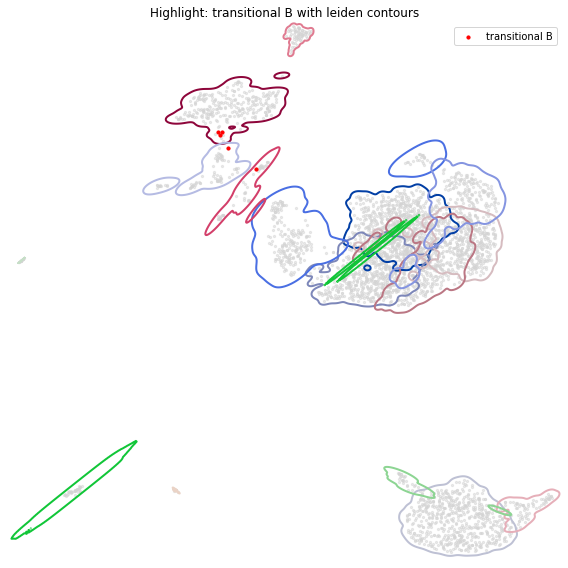

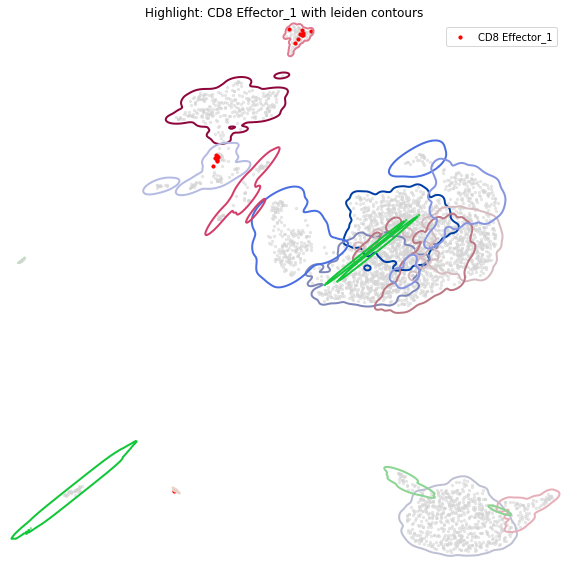

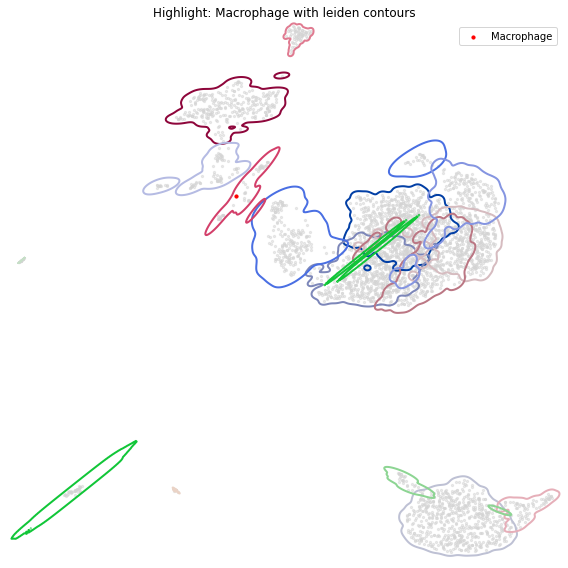

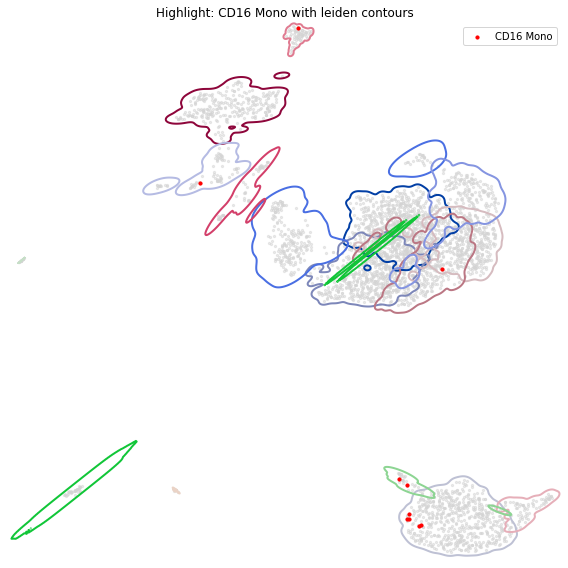

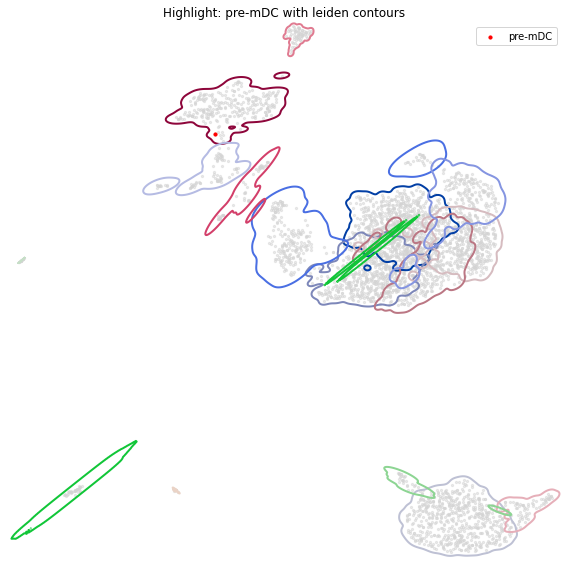

time: 56.5 s (started: 2025-05-06 09:17:48 +02:00)


In [41]:
for celltype in adata.obs['predicted.celltype.l2'].unique():
    fig, ax = plot_umap_with_cluster_contours( adata,
        contour_group="leiden", 
        subset_group="predicted.celltype.l2", 
        cells_selected = celltype,
        contour_linewidth = 2,
        contour_alpha = 1.0,
    )
    fig.savefig( f"{experiment}_leiden_outline_predicted_celltype_l2_{celltype}.svg")

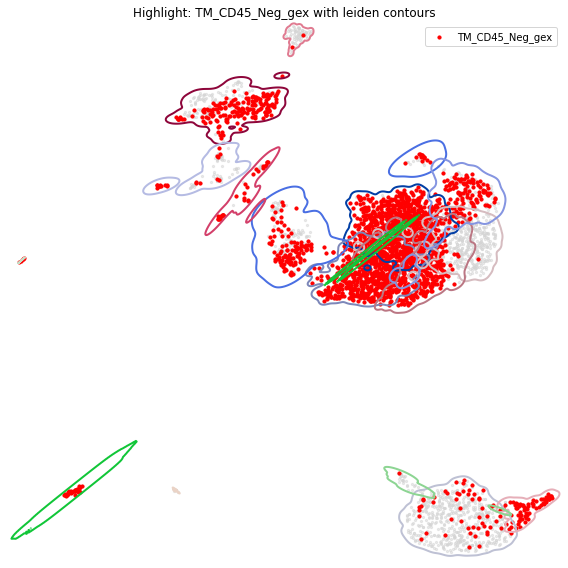

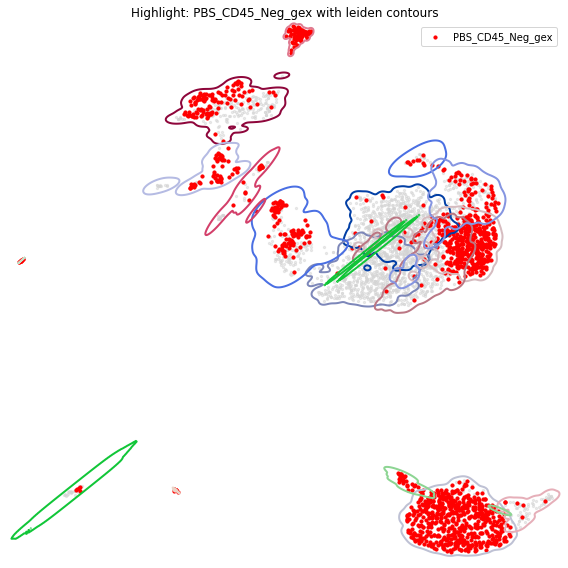

time: 6.8 s (started: 2025-05-06 09:18:44 +02:00)


In [42]:
for celltype in adata.obs['sname'].unique():
    fig, ax = plot_umap_with_cluster_contours( adata,
        contour_group="leiden", 
        subset_group="sname", 
        cells_selected = celltype,
        contour_linewidth = 2,
        contour_alpha = 1.0,
    )
    fig.savefig( f"{experiment}_leiden_outline_sname_{celltype}.svg")


In [43]:
[ n for n in adata.var_names if n.startswith('Il5') ]

['Il5ra']

time: 4.93 ms (started: 2025-05-06 09:18:51 +02:00)


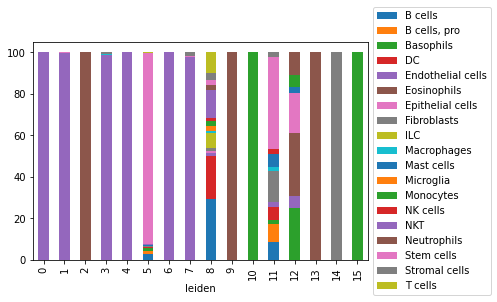

time: 879 ms (started: 2025-05-06 09:18:51 +02:00)


In [44]:
import matplotlib.pyplot as plt
sname_tab = adata.obs.pivot_table(values = "n_genes", index = "leiden", columns="label", aggfunc='count')
sname_tab_scaled = sname_tab.apply( scale_values, axis=1,  result_type='expand')
ax = sname_tab_scaled.plot.bar(stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"Micke_{experiment}_from_raw_label_vs_louvain_stacked_bar_plot.svg", format='svg', bbox_inches='tight')
plt.show()

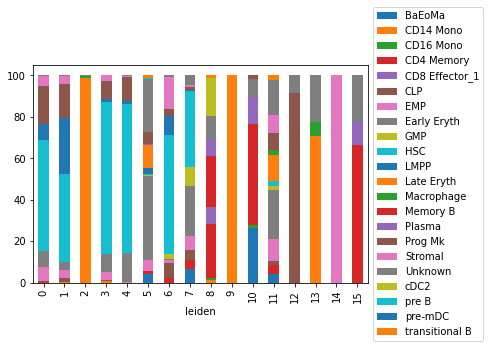

time: 985 ms (started: 2025-05-06 09:18:52 +02:00)


In [45]:
import matplotlib.pyplot as plt
sname_tab = adata.obs.pivot_table(values = "n_genes", index = "leiden", columns="predicted.celltype.l2", aggfunc='count')
sname_tab_scaled = sname_tab.apply( scale_values, axis=1,  result_type='expand')
ax = sname_tab_scaled.plot.bar(stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Micke_Exp1_from_raw_predicted_celltype_l2_vs_louvain_stacked_bar_plot.svg', format='svg', bbox_inches='tight')
plt.show()

# ChatGPT question:

Morning Chatty - which genes would preced the Hemoglobin expression in Red cell development? 5 would be cool - please as Python array with a follow up description of these fenes (after the array).
ChatGPT:

Good morning! Here's your Python array with five genes that precede hemoglobin (HBB, HBA1, HBA2) expression in red blood cell (erythroid) development:

genes_preceding_hemoglobin = ["GATA1", "TAL1", "KLF1", "LMO2", "EPOR"]

Gene Descriptions:

    GATA1 – A master transcription factor for erythropoiesis. It activates genes involved in red blood cell maturation, including hemoglobin genes, and represses genes associated with alternative cell fates.

    TAL1 (SCL) – Essential for hematopoiesis, this transcription factor works with GATA1 to drive erythroid lineage commitment and hemoglobin production.

    KLF1 (EKLF) – A key erythroid transcription factor that regulates β-globin expression and is critical for proper hemoglobin switching from fetal (γ-globin) to adult (β-globin) forms.

    LMO2 – Functions as a transcriptional regulator in early hematopoietic progenitor cells and plays a role in erythroid differentiation.

    EPOR (Erythropoietin Receptor) – This receptor binds erythropoietin (EPO) and initiates signaling cascades that drive erythroid precursor proliferation and survival, ensuring sufficient red blood cell production before hemoglobin synthesis.

Let me know if you want more details or additional genes! 🚀


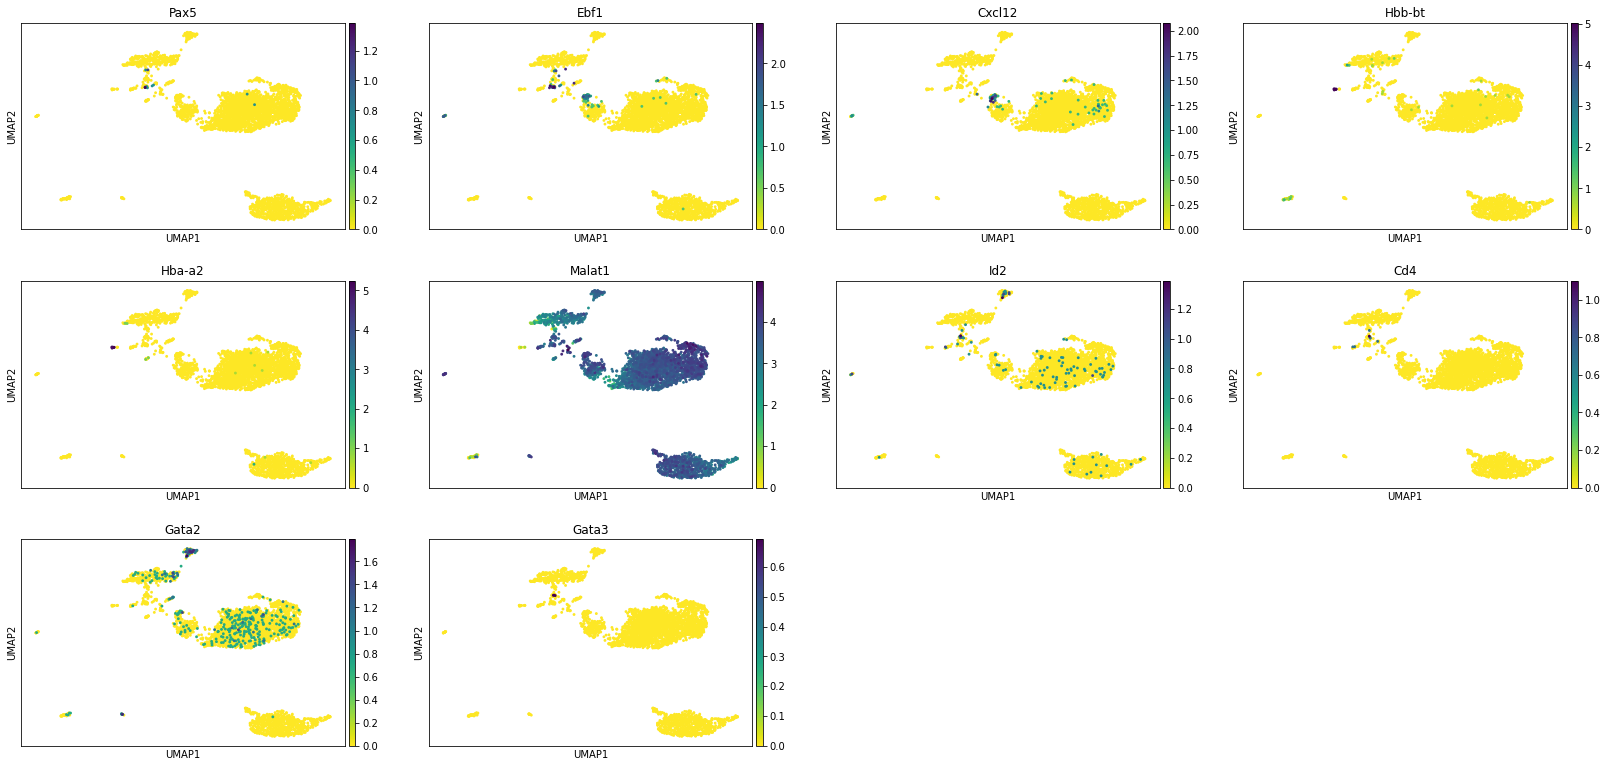

Chattie's genes_preceding_hemoglobin

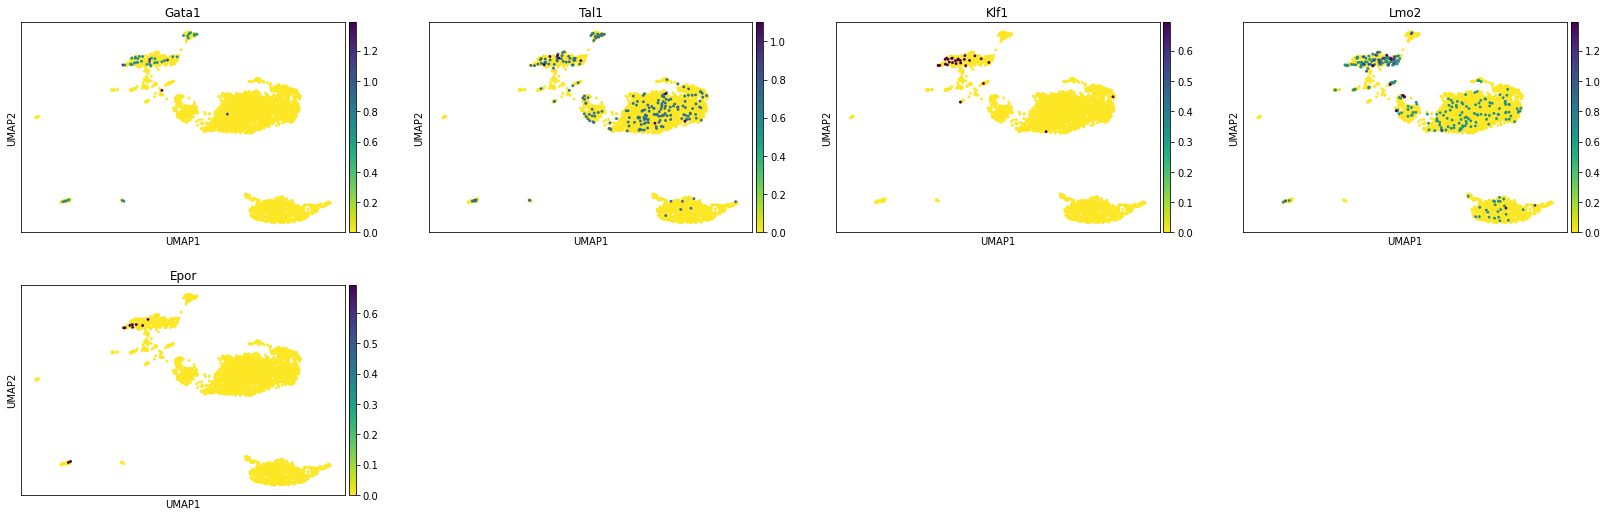

Is that correct?

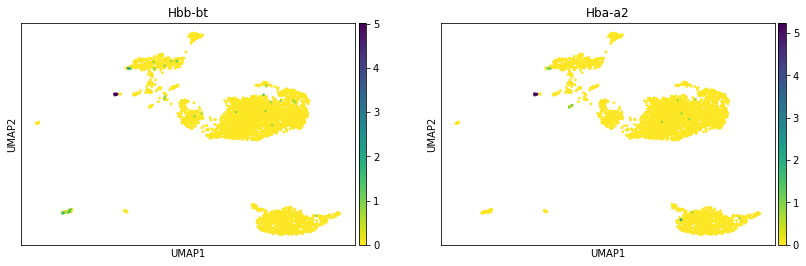

time: 1.92 s (started: 2025-05-06 09:18:53 +02:00)


In [46]:
genes_preceding_hemoglobin = ["Gata1", "Tal1", "Klf1", "Lmo2", "Epor"]
scanpy.pl.umap(adata, color=[ 'Pax5', 'Ebf1','Cxcl12', 'Hbb-bt', 'Hba-a2', 'Malat1', "Id2", "Cd4", "Gata2", "Gata3"],
                   legend_loc='right margin', cmap="viridis_r")

print ("Chattie's genes_preceding_hemoglobin")
scanpy.pl.umap(adata, color=genes_preceding_hemoglobin,
                   legend_loc='right margin', cmap="viridis_r")
print("Is that correct?")
scanpy.pl.umap(adata, color=[ 'Hbb-bt', 'Hba-a2'],
                   legend_loc='right margin', cmap="viridis_r")

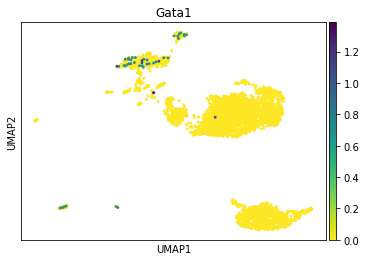

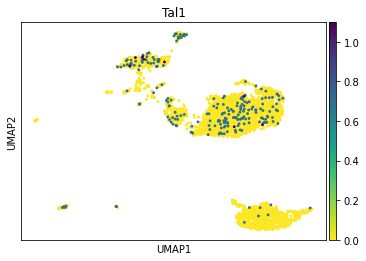

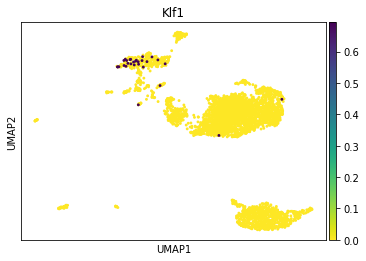

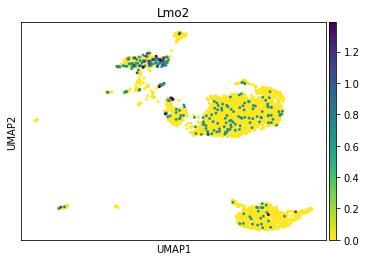

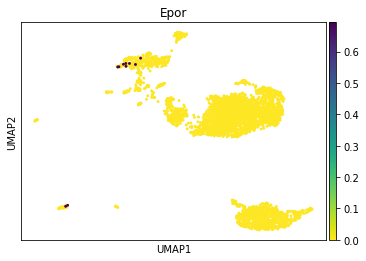

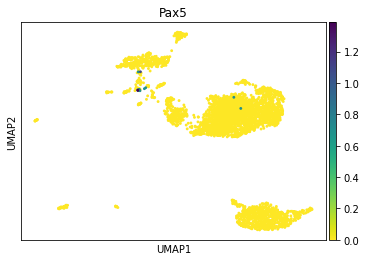

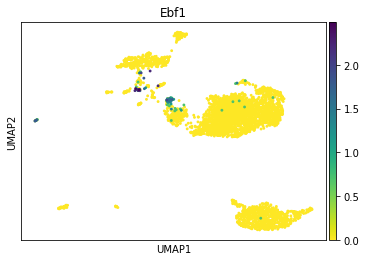

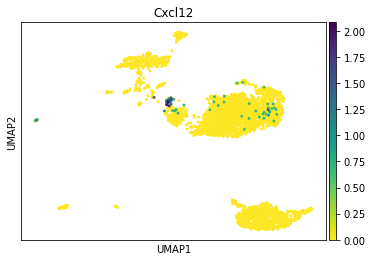

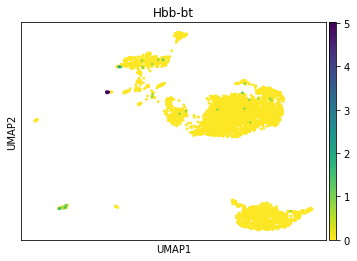

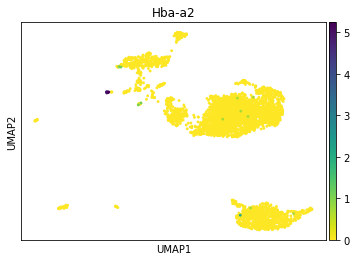

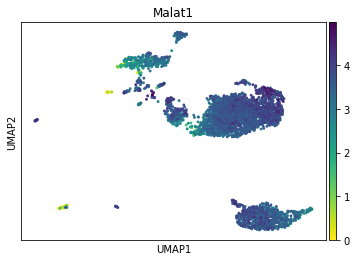

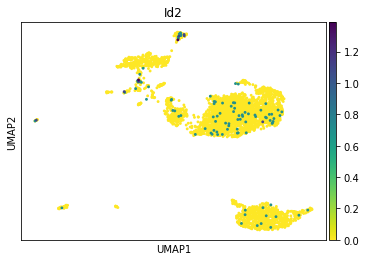

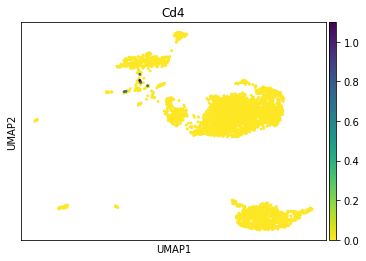

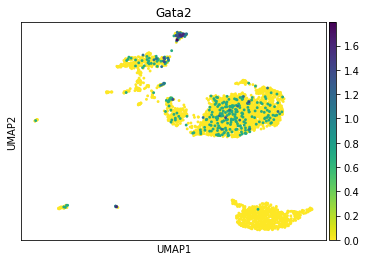

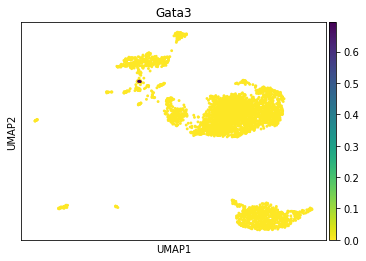

time: 4.99 s (started: 2025-05-06 09:18:55 +02:00)


In [47]:
all_gois = [ "Gata1", "Tal1", "Klf1", "Lmo2", "Epor", 'Pax5', 'Ebf1','Cxcl12', 'Hbb-bt', 'Hba-a2', 'Malat1', "Id2", "Cd4", "Gata2", "Gata3" ]
for goi in all_gois:
    if goi in adata.var_names:
        scanpy.pl.umap(adata, color= goi,
                   legend_loc='right margin', cmap="viridis_r", save=f"_{experiment}_{goi}_expression.svg")
    else:
        print(f"{goi} is not part of this analysis!")

# Both Cell Type annotations are crap

The mouse SingleR "label" does not even include Erythrozytes and the Human Azimuth data does missclassify a lot of not Ery cells as early Ery and also labels some later Ery as early.

## Manual classification of the Red cells?

I think that is crearly visible is that Klf1 and Epor start to be expressed in the cells that are found mainly in the Spleen (Leiden Cluster6). The cells in leiden clusters 0,2 and 3 mainly contain the cells from the TM Spleen. These cells express Epor and Klf1, but not (just) the Hemoglobins. So in a way this could explain why the mice die. The massive need in red cells seams to have triggered a massive expansion of the easrly Ery state possibly leading to an energy depletion and slower production rate leading untimately to not meeting red cell demands and likely anemia. Would be absolutely cool if your lab data would show something link that.

I think at the end of the day we are more save with stating something like that (possibly without the hypothesis) instead of using the Azimuth predictions. 

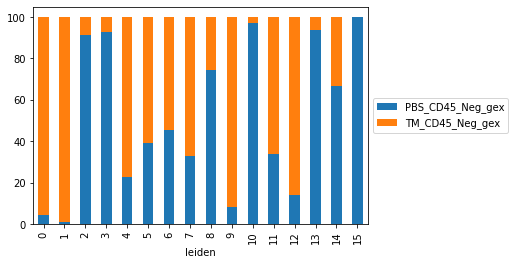

time: 262 ms (started: 2025-05-06 09:19:00 +02:00)


In [48]:


import matplotlib.pyplot as plt
sname_tab = adata.obs.pivot_table(values = "n_genes", index = "leiden", columns="sname", aggfunc='count')
sname_tab_scaled = sname_tab.apply( scale_values, axis=1,  result_type='expand')
ax = sname_tab_scaled.plot.bar(stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"Micke_{experiment}_from_raw_sname_vs_louvain_stacked_bar_plot.svg", format='svg', bbox_inches='tight')
plt.show()

In [49]:
sname_tab

sname   PBS_CD45_Neg_gex  TM_CD45_Neg_gex
leiden                                   
0                     34              723
1                      7              643
2                    552               54
3                    330               26
4                     65              224
5                    110              170
6                    103              125
7                     61              126
8                     61               21
9                      6               65
10                    66                2
11                    16               31
12                     5               31
13                    29                2
14                    10                5
15                     9                0

time: 4.02 ms (started: 2025-05-06 09:19:00 +02:00)


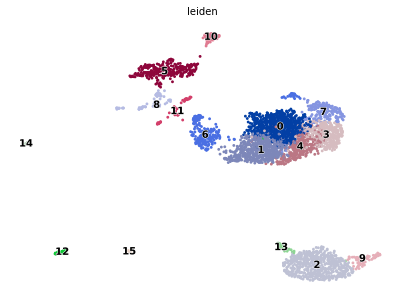

time: 254 ms (started: 2025-05-06 09:19:00 +02:00)


In [50]:
scv.pl.scatter(adata, color=[ 'leiden', ], figsize =(7,5), legend_loc='on data')

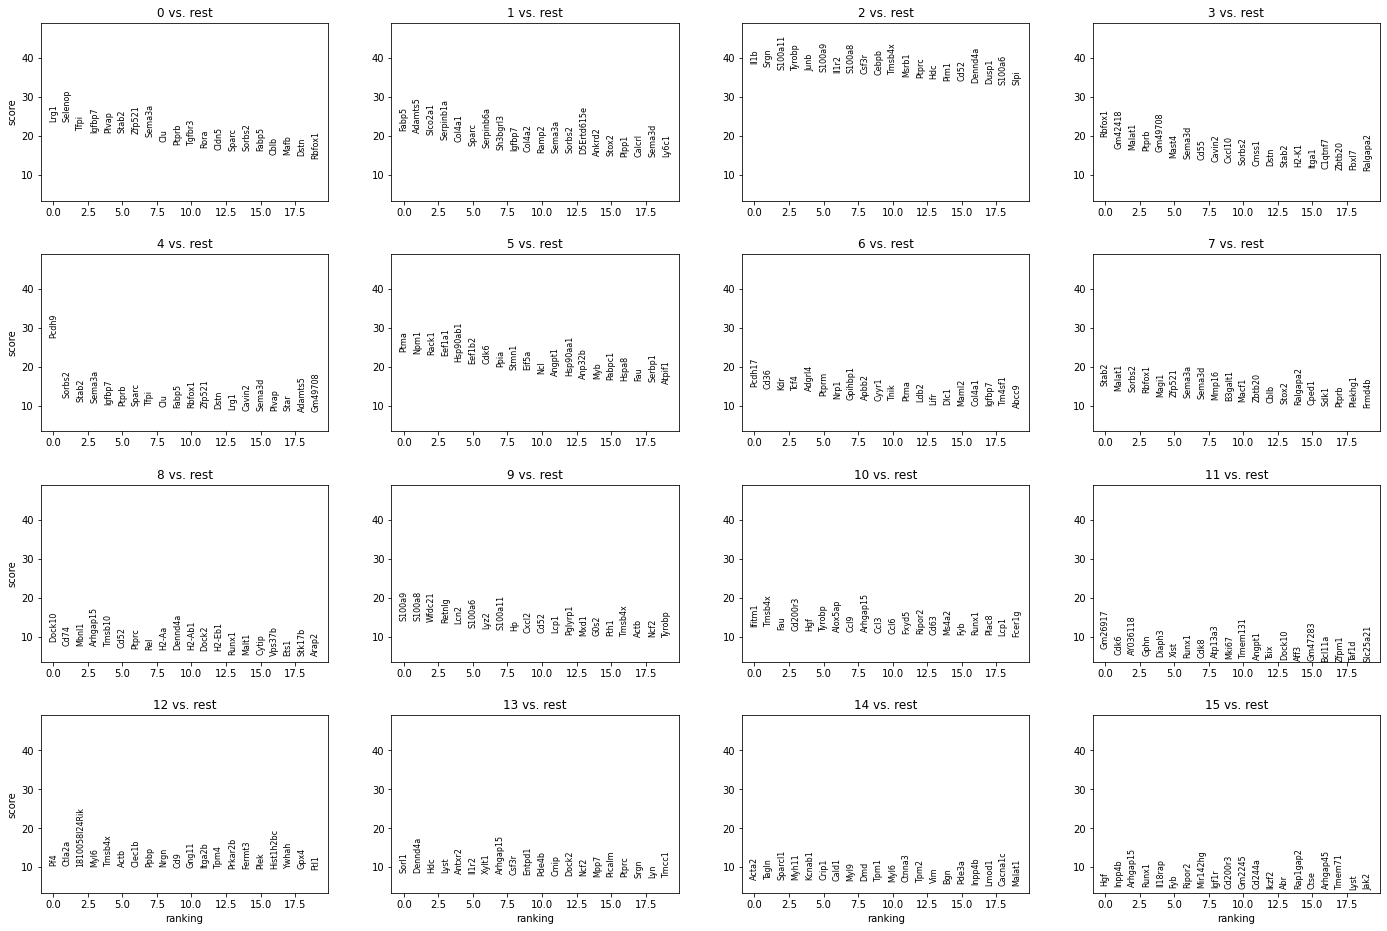

[Errno 17] File exists: 'exp3_single_leiden_stats'

time: 7.85 s (started: 2025-05-06 09:19:01 +02:00)


In [51]:
write_stats_tables( adata, f"{experiment}_single_leiden_stats")

In [52]:
adata.write( ofile )
! ls -lhrt {ofile}

-rw-r--r-- 1 stefanl lu-shso 43M May  6 09:19 Experiment3_celltypes.h5ad
time: 493 ms (started: 2025-05-06 09:19:08 +02:00)


In [53]:
adata = anndata.read(ofile)
adata

AnnData object with n_obs × n_vars = 3712 × 17929
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'mapping.score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geneSum', 'RP[LS]sum', 'MTsum', 'leiden'
    var: 'n_counts', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'exp3_single_leiden_stats', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'predicted.celltype.l2_colors', 'sname_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

time: 199 ms (started: 2025-05-06 09:19:09 +02:00)


In [54]:
adata.obs['sname'].value_counts()

sname
TM_CD45_Neg_gex     2248
PBS_CD45_Neg_gex    1464
Name: count, dtype: int64

time: 5.46 ms (started: 2025-05-06 09:19:09 +02:00)


# Ery story - are there differences in the cells between PBS and TM?

I will comapre in each cluster the TM_Spl to the PBS_Spl:

clusters = c[0,2,3,5,6,11,16]

# Does not apply here!figures/umapexpfigures/umapexp

In [ ]:
clusters = [0,2,3,5,6,11,16]
for cluster in clusters:
    tmp = adata[adata.obs['leiden'] == str( cluster ) ]
    print(f"cluster{cluster}")
    print (tmp)
    tmp = tmp[ tmp.obs['sname'].isin(['PBS_Spl', 'TM_Spl'])]
    tmp.obs['sname']= tmp.obs['sname'].astype('str').astype('category') # get rid of the BM sample name
    print( tmp.obs['sname'].value_counts())
    write_stats_tables( tmp, f"{experiment}_Spleen_single_leiden_cluster{cluster}_sname_stats", "sname")

In [ ]:
for sname in adata.obs['sname'].unique():
    print(f"Sample {sname} - is hem synthesis starting?")
    tmp = adata[adata.obs['sname'] == sname ]
    scanpy.pl.umap(tmp, color=[ 'Hbb-bt', 'Hba-a2'],
                   legend_loc='right margin', cmap="viridis_r")

In [ ]:
adata

In [ ]:
adata.obs['predicted.celltype.l2'].value_counts()

In [ ]:
adata.obs['sname'].value_counts()

In [ ]:
clusters = ['Late Eryth']
for cluster in clusters:
    tmp = adata[adata.obs['predicted.celltype.l2'] == str( cluster ) ]
    print(f"cluster{cluster}")
    print (tmp)
    tmp = tmp[ tmp.obs['sname'].isin(['PBS_Spl', 'TM_Spl'])]
    tmp.obs['sname']= tmp.obs['sname'].astype('str').astype('category') # get rid of the BM sample name
    print( tmp.obs['sname'].value_counts())
    write_stats_tables( tmp, f"{experiment}_Spleen_single_predicted.celltype.l2_cluster{cluster}_sname_stats", "sname")

# Extension 1

Micke asked if I could create a heatmal for the genes 

genes = ["Ki67", "KitL", "CSF1", "CSF2", "CSF3", "TNF", 
"IL3", "Il1b", "IL1a", "FGF1", "Lif", 
"Osm", "Il6", "Fgf21", "Il33", "Cxcl2", 
"Ctla4", "Il7", "CCl17", "HGF", "Il17f", "Ccl2", "Il10", "Ccl12", 
"Ccl4", "CCl22", "CCL11", "Cxcl9", "Il16"]

And "Oncostatin m" is likely not a gene...

In [6]:
adata = anndata.read_h5ad(ofile)

time: 241 ms (started: 2025-06-02 08:52:33 +02:00)


In [184]:
genes_req = ["Ki67", "KitL", "CSF1", "CSF2", "CSF3", "TNF", 
"IL3", "Il1b", "IL1a", "FGF1", "Lif", 
"Osm", "Il6", "Fgf21", "Il33", "Cxcl2", 
"Ctla4", "Il7", "CCl17", "HGF", "Il17f", "Ccl2", "Il10", "Ccl12", 
"Ccl4", "CCl22", "CCL11", "Cxcl9", "Il16"]

genes = [ gene.capitalize() for gene in adata.var_names if gene.capitalize() in genes_req ]
genes

['Ctla4',
 'Il10',
 'Il1b',
 'Il7',
 'Il6',
 'Cxcl2',
 'Cxcl9',
 'Il16',
 'Osm',
 'Lif',
 'Ccl2',
 'Ccl4',
 'Il33']

time: 8.23 ms (started: 2025-06-02 11:18:25 +02:00)


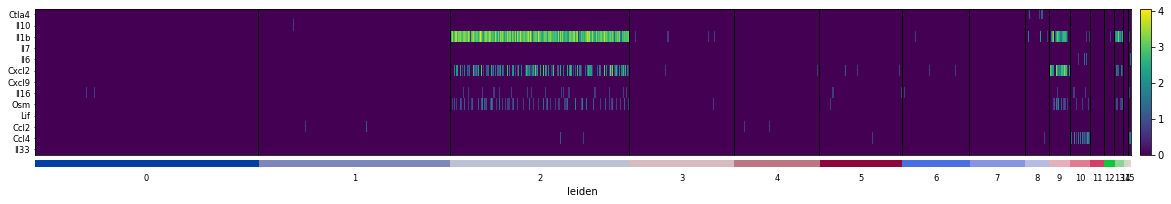

time: 468 ms (started: 2025-06-02 11:38:33 +02:00)


In [216]:
scanpy.pl.heatmap(adata,genes, groupby="leiden", swap_axes=True, show_gene_labels=True, standard_scale=True,figsize=[20,3], 
                  save=f"_{experiment}_leiden_all_cells.svg")

In [206]:
cluster_key = "leiden"
n_cells_per_cluster = 10

# Store the mean expression profiles per cluster
mean_profiles = []
rnames=[]

for cluster in adata.obs[cluster_key].unique():
    # Subset cells in the current cluster
    adata_cluster = adata[adata.obs[cluster_key] == cluster]
    this_target = n_cells_per_cluster
    if len(adata_cluster.var_names) < n_cells_per_cluster:
        this_target = len(adata_cluster.var_names)
    if this_target == 0:
        print(f"Cluster {cluster} does not have any cells?!")
        continue
    # Shuffle and split into chunks of ~equal size (e.g. 10 random subsets)
    idx = np.random.permutation(adata_cluster.n_obs)
    split_indices = np.array_split(idx, this_target)
    rid=0
    
    for sub_idx in split_indices:
        # Mean expression for this subset
        if len(sub_idx) == 0:
            print(f"The sub_idx for Cluster {cluster} has zero entries?!")
            continue
        rnames.append( f"leiden{cluster}#{rid}" )
        rid +=1
        mean_expr = adata_cluster[sub_idx].X.mean(axis=0)
        mean_profiles.append(np.asarray(mean_expr).flatten())  # convert sparse if needed
    
# Convert to a DataFrame
mean_expr_df = pd.DataFrame(mean_profiles, columns=adata.var_names, index= rnames)


The sub_idx for Cluster 15 has zero entries?!

time: 974 ms (started: 2025-06-02 11:23:33 +02:00)


In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

def summary_heatmap( df ):
    leiden_ids = df.index.str.extract(r"leiden(\d+)").iloc[:, 0].astype(int)
    #print (leiden_ids)
    sorted_positions = leiden_ids.argsort()
    df = df.iloc[sorted_positions]
    
    # Extract leiden cluster IDs as strings
    leiden_ids = df.index.str.extract(r"leiden(\d+)").iloc[:, 0]
    # Create palette and lut
    #print(leiden_ids)
    unique_ids = leiden_ids.unique()
    #print ( unique_ids )
    palette = sns.color_palette("hls", len(unique_ids))
    lut = dict(zip(unique_ids, palette))
    col_colors = [lut[id] for id in leiden_ids]

    adata_pseudo = anndata.AnnData(df)
    adata_pseudo.obs['leiden'] = pd.Categorical(leiden_ids.values.astype(int), ordered=True)
    #print(adata_pseudo.obs['leiden'])
    adata_pseudo.uns['leiden_colors'] = adata.uns.get('leiden_colors', None)    
    # Now plot heatmap grouped by leiden
    plt =scanpy.pl.heatmap(
        adata_pseudo,
        var_names=adata_pseudo.var_names,
        swap_axes=True, 
        show_gene_labels=True,
        groupby='leiden',
        cmap='viridis',
        standard_scale='var',
        show=True,
        save=f"_{experiment}_leiden_10_mean_cells.svg"
    )   
    plt



time: 873 µs (started: 2025-06-02 11:23:33 +02:00)


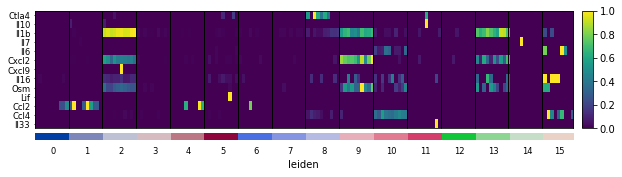

time: 905 ms (started: 2025-06-02 11:23:34 +02:00)


In [208]:
summary_heatmap( mean_expr_df[genes] )

In [7]:
adata = anndata.read(ofile)
adata

AnnData object with n_obs × n_vars = 3712 × 17929
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'mapping.score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geneSum', 'RP[LS]sum', 'MTsum', 'leiden'
    var: 'n_counts', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'exp3_single_leiden_stats', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'predicted.celltype.l2_colors', 'sname_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

time: 227 ms (started: 2025-08-26 11:10:49 +02:00)


In [18]:
import sys
sys.path.append('/home/stefanl/import/')
if "functions" in sys.modules:
    print("Removinf old functions module")
    del sys.modules['functions']
import functions

Removinf old functions module

time: 3.73 ms (started: 2025-08-26 12:09:17 +02:00)


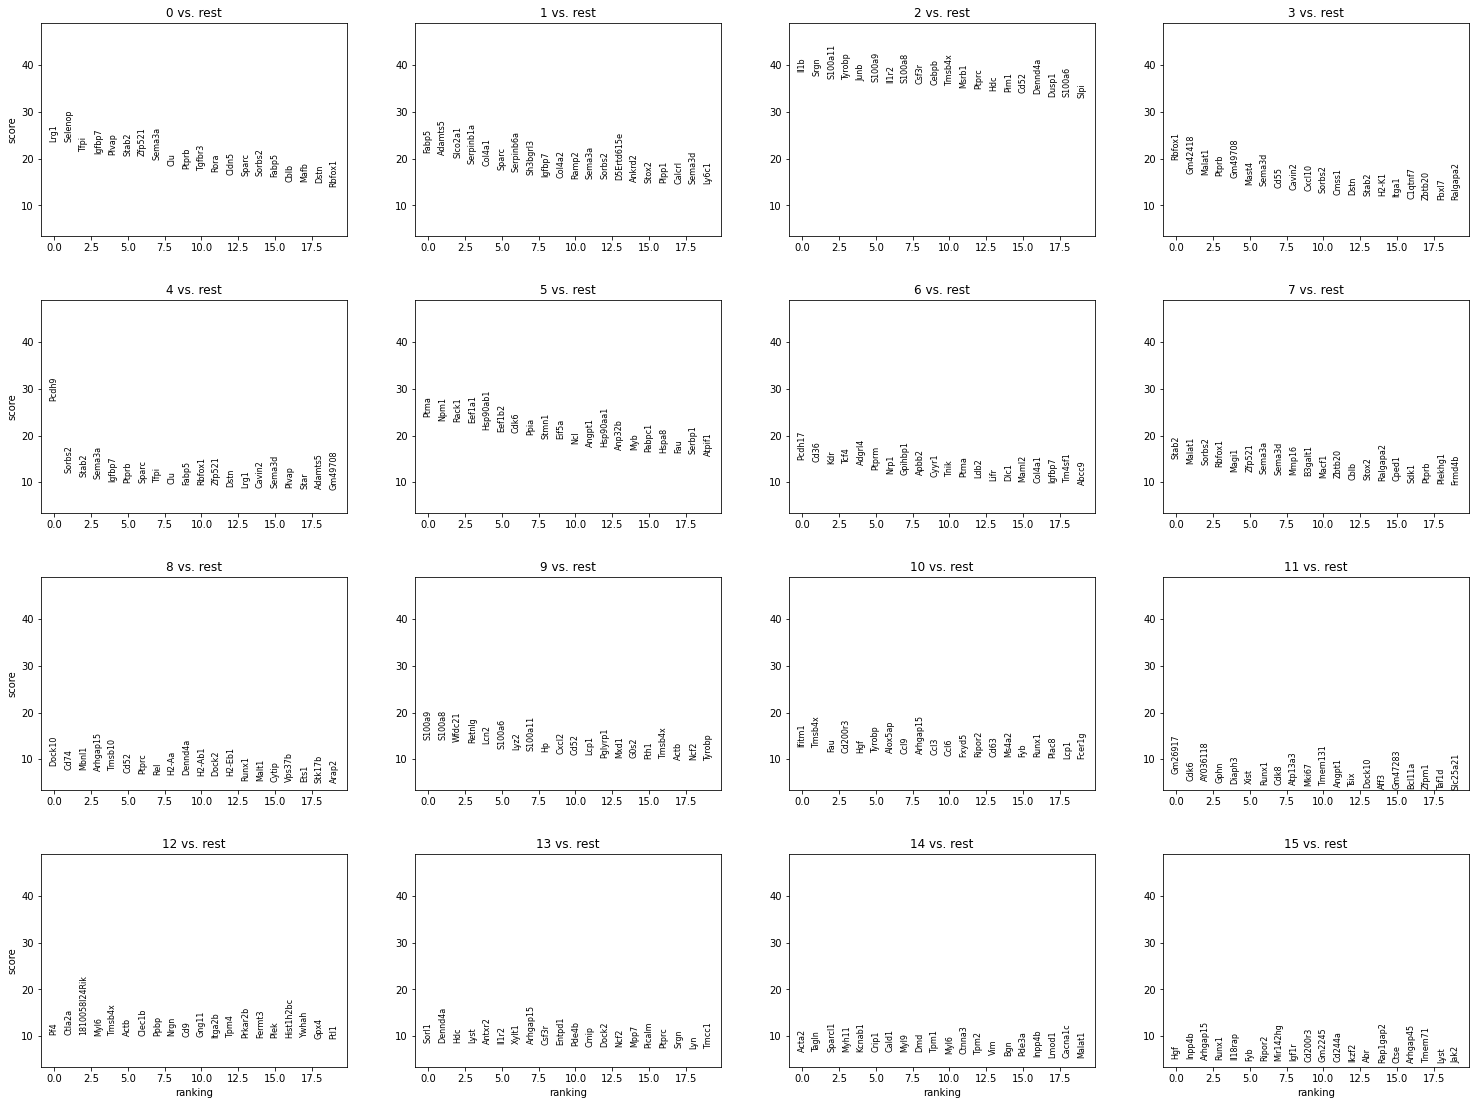

[Errno 17] File exists: 'exp3_single_leiden_stats'
time: 6.42 s (started: 2025-08-26 11:10:52 +02:00)


In [9]:
functions.write_stats_tables(  adata, f"{experiment}_single_leiden_stats", 'leiden')

In [10]:
# Define lineages for both label sets
lineages = {
    "Stem/Progenitor": ["Stem cells", "LMPP", "GMP", "Prog Mk", "EMP", "HSC", "CLP"],
    "Erythroid": ["Early Eryth", "Late Eryth"],
    "Myeloid": ["DC", "Basophils", "Neutrophils", "Monocytes", "Macrophages",
                "Mast cells", "Microglia", "Eosinophils", "CD16 Mono", "CD14 Mono",
                "BaEoMa", "cDC2", "pre-mDC", "ASDC", "pre-pDC", "pDC"],
    "Lymphoid": ["B cells", "B cells, pro", "T cells", "NKT", "Tgd", "Memory B",
                 "Plasma", "transitional B", "pre B", "CD4 Memory", "CD8 Effector_1", "CD8 Memory"],
    "NK/ILC": ["ILC", "NK cells"],
    "Stromal/Other": ["Endothelial cells", "Epithelial cells", "Fibroblasts", "Stromal cells", "Stromal", "Unknown"],
}

# Base colors for lineages
base_colors = {
    "Stem/Progenitor": "#1f77b4",
    "Erythroid": "#d62728",
    "Myeloid": "#ff7f0e",
    "Lymphoid": "#2ca02c",
    "NK/ILC": "#9467bd",
    "Stromal/Other": "#8c564b",
}

# Build color maps
color_map = {}
for lineage, members in lineages.items():
    shades = functions.generate_distinct_shades(base_colors[lineage], len(members))
    for cell_type, shade in zip(members, shades):
        color_map[cell_type] = shade

time: 1.73 ms (started: 2025-08-26 11:11:14 +02:00)


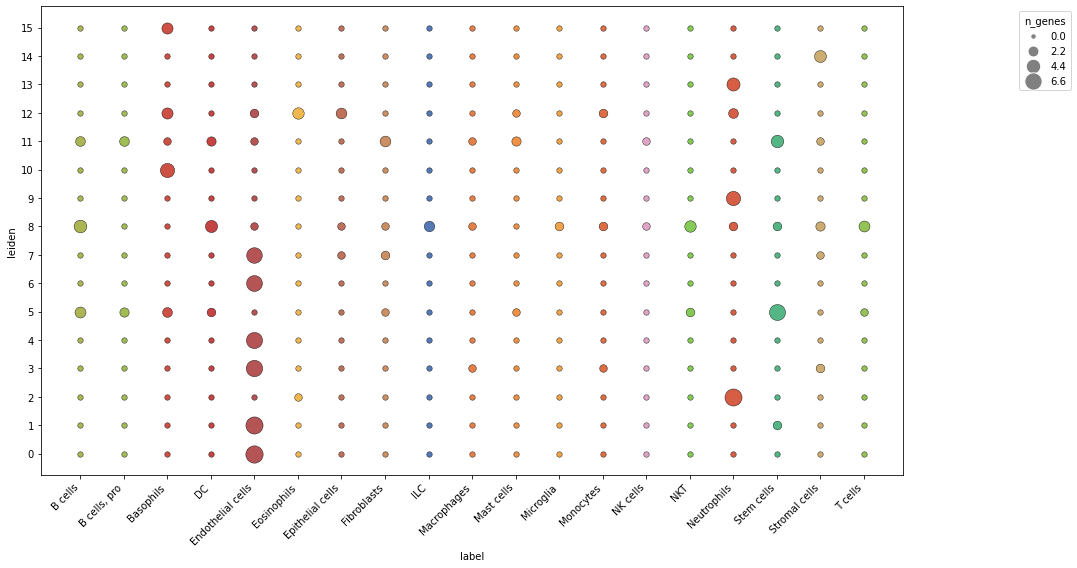

saved as Micke_exp3_log1p_label_dot_plot.svg

time: 3.39 s (started: 2025-08-26 12:20:29 +02:00)


In [25]:
x_col="label"
save_path=f"Micke_{experiment}_log1p_{x_col}_dot_plot.svg"

functions.plot_dotplot_matrix_legend( 
    adata, value_col="n_genes", x_col=x_col, y_col="leiden", 
    color_map = color_map,
    scale_func = None,
    figsize=(15,8),
    log_transform=True,
    title=None,
    save_path=save_path
)
print( f"saved as {save_path}" )

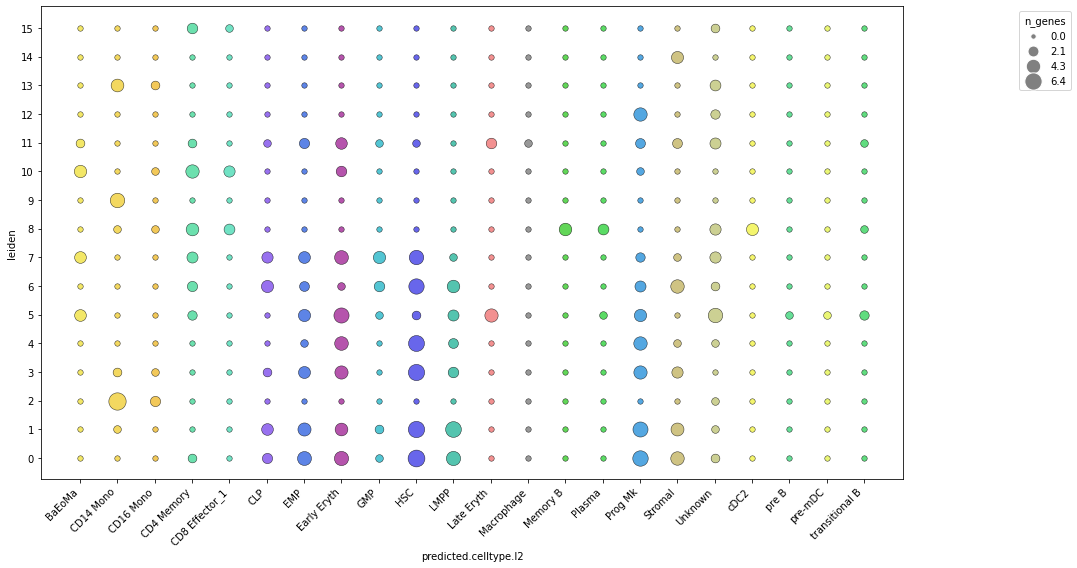

saved as Micke_exp3_from_raw_log1p_trans_predicted.celltype.l2_vs_louvain_dot_plot.svg

time: 4.23 s (started: 2025-08-26 12:20:46 +02:00)


In [26]:
x_col="predicted.celltype.l2"
save_path=f"Micke_{experiment}_from_raw_log1p_trans_{x_col}_vs_louvain_dot_plot.svg"
functions.plot_dotplot_matrix_legend( 
    adata, value_col="n_genes", x_col="predicted.celltype.l2", y_col="leiden", 
    color_map = color_map,
    scale_func = None,
    figsize=(15,8),
    log_transform=True,
    title=None,
    save_path=save_path
)
print( f"saved as {save_path}" )

Index(['Xkr4', 'Sox17', 'Gm37587', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h',
       'Rb1cc1', '4732440D04Rik', 'St18',
       ...
       'AC125149.2', 'AC133103.1', 'CAAA01118383.1', 'Csprs', 'Vamp7', 'Tmlhe',
       '4933409K07Rik', 'Gm10931', 'CAAA01147332.1', 'AC149090.1'],
      dtype='object', length=17929)

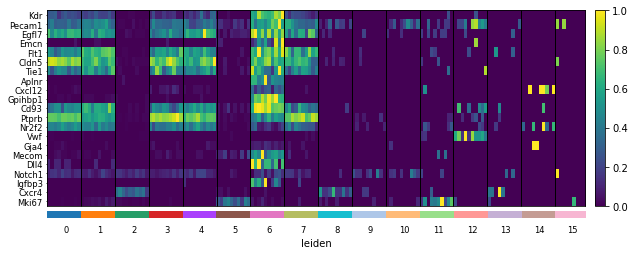

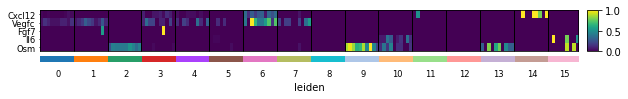

time: 1.22 s (started: 2025-08-26 12:09:38 +02:00)


In [20]:
Endothelial_markers = ['Kdr', 'Pecam1', 'Egfl7', 'Emcn', 'Flt1', 'Cldn5', 'Tie1', 'Aplnr', 'Cxcl12', 'Gpihbp1', 'Cd93', 'Ptprb', 'Apk', 'Nr2f2', 'Vwf', 'Gja4', 'Mecom', 'Dll4', 'Notch1', 'Igfbp3', 'Cxcr4', 'Mki67']
Niche_markers = ['Cxcl12', 'KitL', 'Cxcl14', 'Bmp 4,Bmp 5', 'Bmp 6', 'Vegfc', 'Fgf7', 'CCL19', 'Il6', 'Osm', 'CCl4', 'Ki67']

pseudo_adata = functions.compute_cluster_mean_profiles_adata(
    adata,
    cluster_key="leiden",
    n_cells_per_cluster=10,
    random_state=42
)
print(pseudo_adata.var_names)

gn = [ g for g in Endothelial_markers if g in pseudo_adata.var_names]
scanpy.pl.heatmap(
    pseudo_adata,
    var_names=gn,
    groupby="leiden",
    standard_scale="var",
    swap_axes=True,
    show=True,
    save=f"_Endothelial_markers_{experiment}_heatmap.svg"
)
gn = [ g for g in Niche_markers if g in pseudo_adata.var_names]
scanpy.pl.heatmap(
    pseudo_adata,
    var_names=gn,
    groupby="leiden",
    standard_scale="var",
    swap_axes=True,
    show=True,
    save=f"_Niche_markers_{experiment}_heatmap.svg"
)

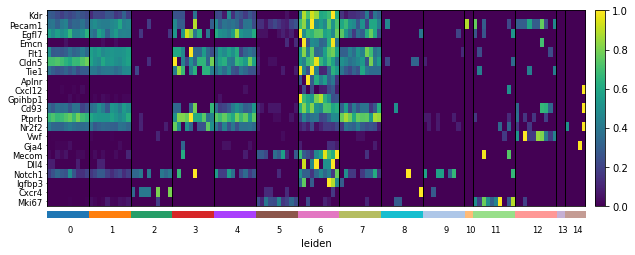

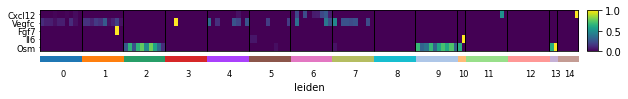

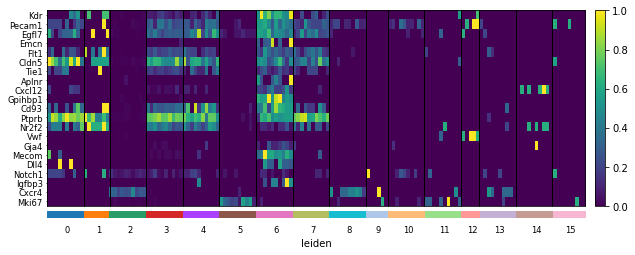

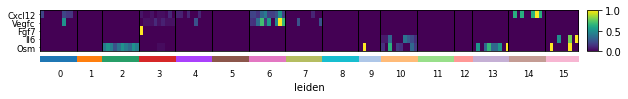

time: 2.23 s (started: 2025-08-26 12:09:51 +02:00)


In [21]:
for sname in adata.obs.sname.unique():
    pseudo_adata = functions.compute_cluster_mean_profiles_adata(
        adata[adata.obs['sname'] == sname],
        cluster_key="leiden",
        n_cells_per_cluster=10,
        random_state=42
    )
    gn = [ g for g in Endothelial_markers if g in pseudo_adata.var_names]
    scanpy.pl.heatmap(
        pseudo_adata,
        var_names=gn,
        groupby="leiden",
        standard_scale="var",
        swap_axes=True,
        show=True,
        save=f"_Endothelial_markers_{experiment}_{sname}_heatmap.svg"
    )
    gn = [ g for g in Niche_markers if g in pseudo_adata.var_names]
    scanpy.pl.heatmap(
        pseudo_adata,
        var_names=gn,
        groupby="leiden",
        standard_scale="var",
        swap_axes=True,
        show=True,
        save=f"_Niche_markers_{experiment}_{sname}_heatmap.svg"
    )

AnnData object with n_obs × n_vars = 25594 × 19738
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 
'predicted.celltype.l2.score', 'mapping.score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 
'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 
'pct_counts_in_top_500_genes', 'geneSum', 'leiden', 'Chatty_celltype'
    var: 'n_counts', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 
'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Chatty_celltype_colors', 'hvg', 'label_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

Overlapping cell names: 3712

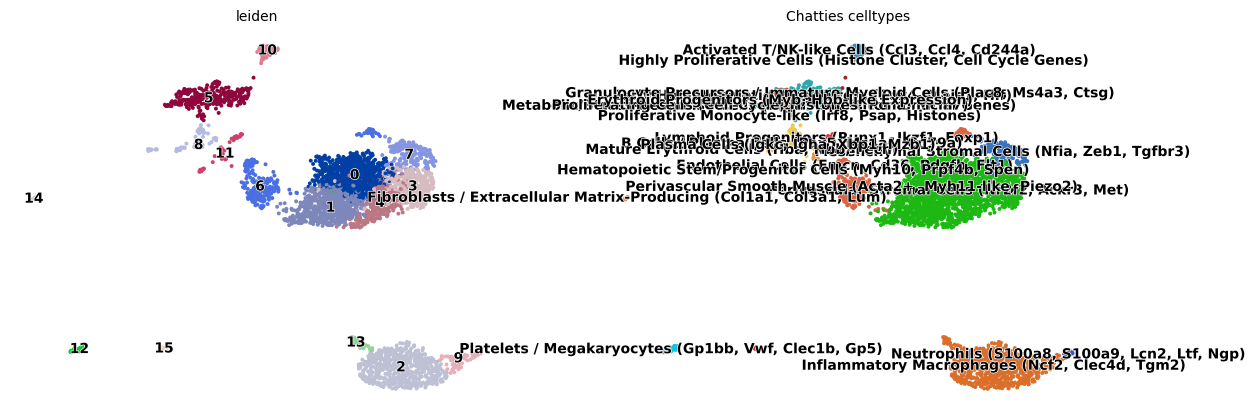

cell,leiden,Chatties_celltypes
AAACCCACACAGTGAG-1,9,"Inflammatory Macrophages (Ncf2, Clec4d, Tgm2)"
AAACCCAGTCGACTTA-1,1,"Perivascular Stromal Cells (Nr2f2, Ackr3, Met)"
AAACCCAGTTTGTTCT-1,12,"Platelets / Megakaryocytes (Gp1bb, Vwf, Clec1b, Gp5)"
AAACGAAAGGCAGGTT-1,0,"Perivascular Stromal Cells (Nr2f2, Ackr3, Met)"
AAACGAAAGGTTCACT-1,0,"Perivascular Stromal Cells (Nr2f2, Ackr3, Met)"
AAACGAACACACAGAG-1,4,"Perivascular Stromal Cells (Nr2f2, Ackr3, Met)"
AAACGAACATCAGTCA-1,6,"Perivascular Smooth Muscle (Acta2+, Myh11-like, Piezo2)"
AAACGCTAGCGACTAG-1,0,"Perivascular Stromal Cells (Nr2f2, Ackr3, Met)"
AAACGCTCATGGTGGA-1,0,"Perivascular Stromal Cells (Nr2f2, Ackr3, Met)"
saving figure to file ./figures/scvelo__exp3_Chatty_celltype.svg


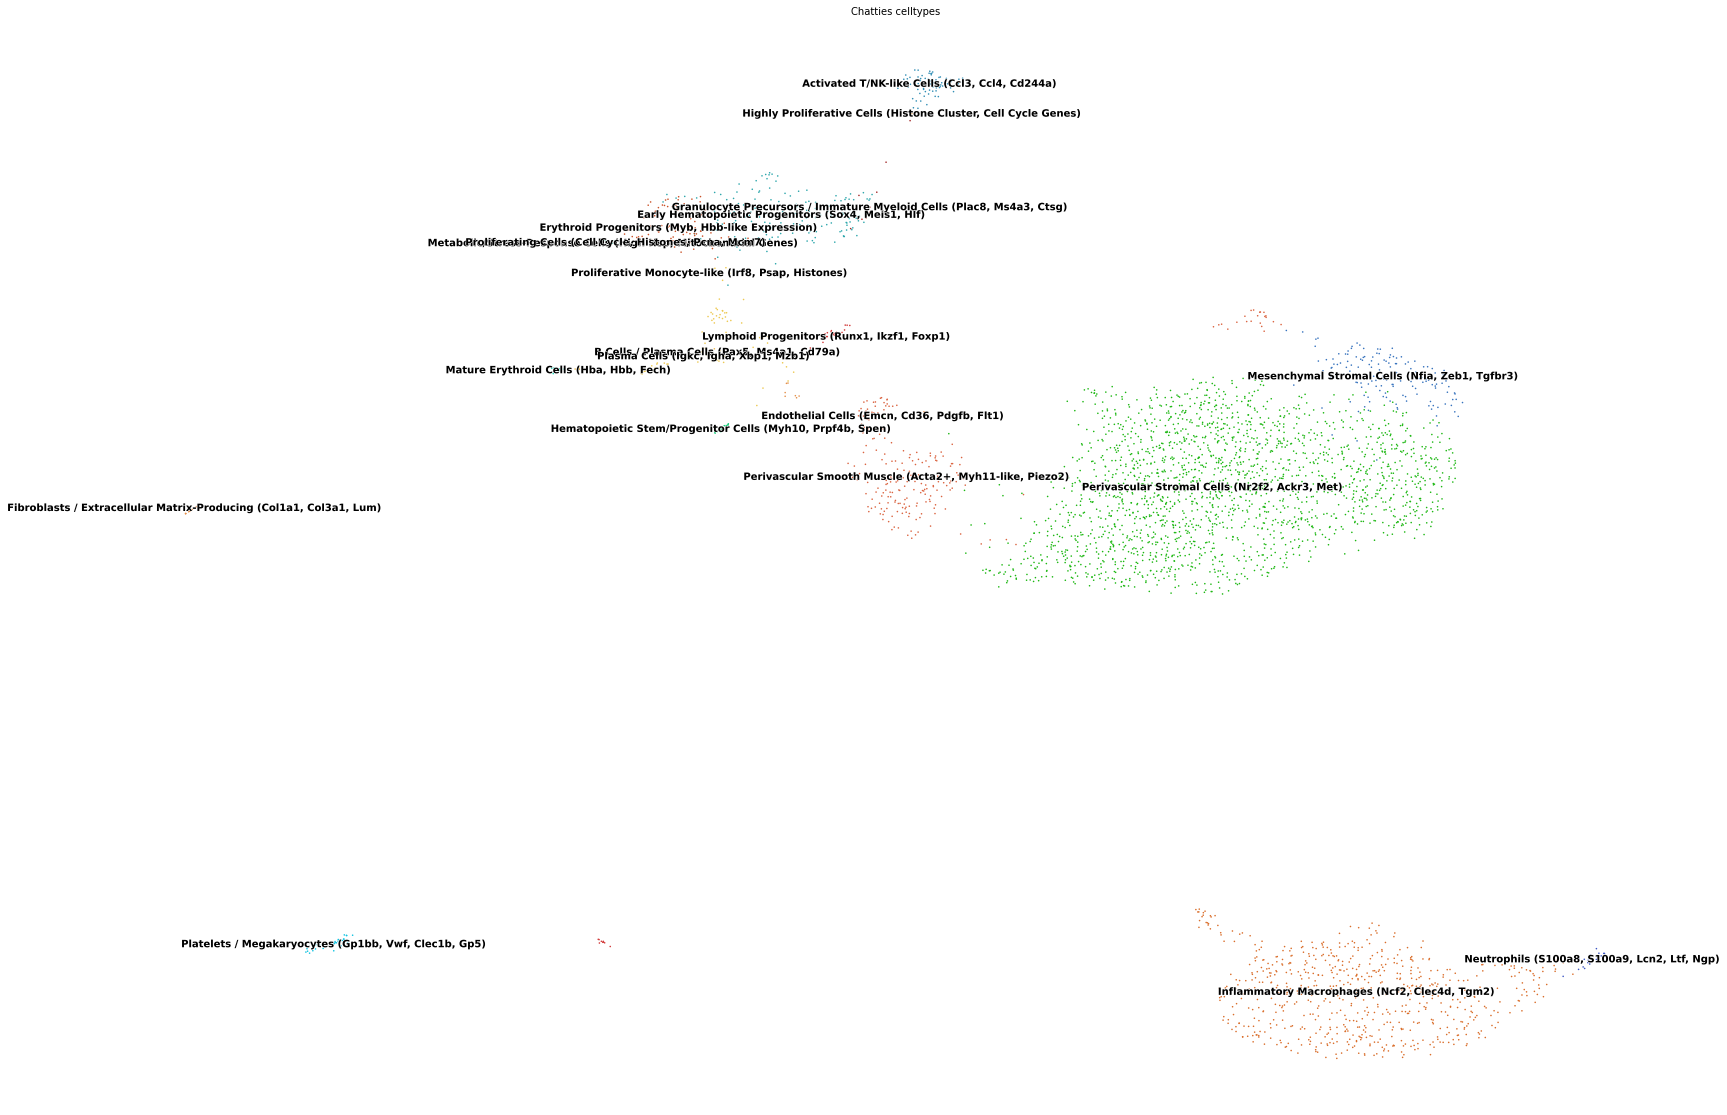

<class 'dict'>

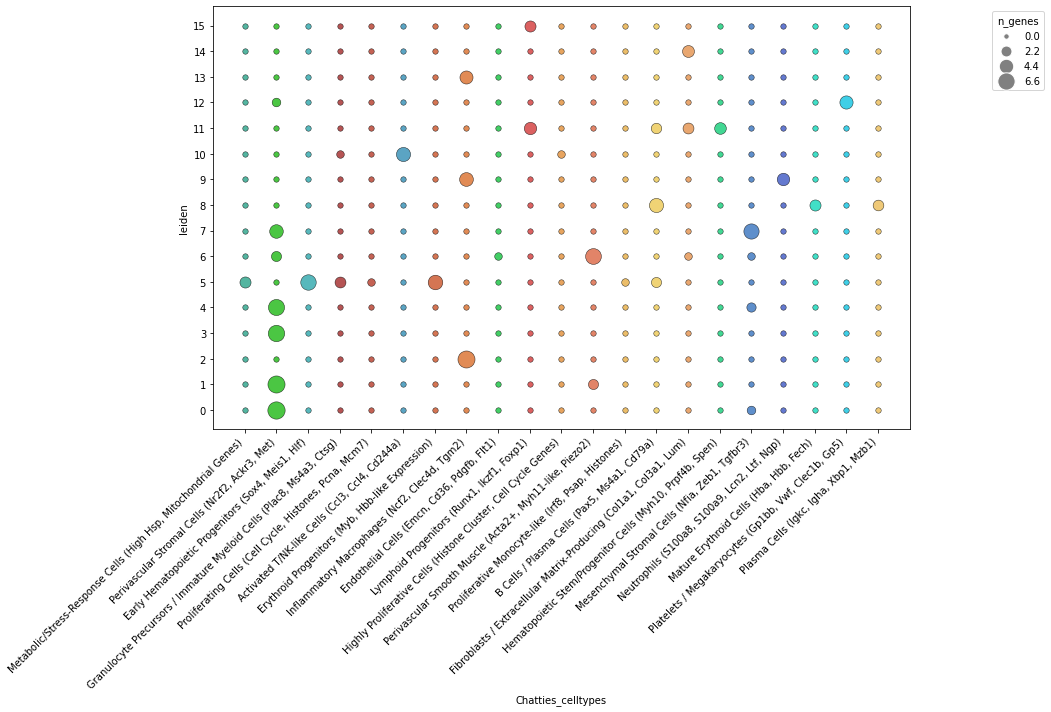

saved as Micke_exp3_from_log1p_trans_Chatties_celltypes_dot_plot.svg

time: 5.62 s (started: 2025-08-27 10:15:28 +02:00)


In [4]:
import sys
sys.path.append('/home/stefanl/import/')
if "functions" in sys.modules:
    print("Removinf old functions module")
    del sys.modules['functions']
import functions

new_grouping = anndata.read(saved)
print(new_grouping)

adata = anndata.read(ofile)
adata.obs_names = adata.obs['cell']
overlap = len([cell for cell in adata.obs_names if cell in new_grouping.obs_names ])
print(f"Overlapping cell names: {overlap}")

adata.obs['Chatties_celltypes'] = new_grouping[adata.obs_names].obs['Chatty_celltype'].values
adata.uns['Chatties_celltypes_colors'] = new_grouping.uns['Chatty_celltype_colors']

scv.pl.scatter(adata, color=[ 'leiden', 'Chatties_celltypes'], figsize =(7,5), legend_loc='on data')

fname =f"{experiment}_leiden_to_Chattyies_celltypes.csv"
adata.obs[['leiden', 'Chatties_celltypes']].to_csv( fname )
! head {fname}

scv.pl.scatter(adata, color=[ 'Chatties_celltypes'], figsize =(28,20),size=10, legend_loc='on data', save=f"_{experiment}_Chatty_celltype.svg", cmap="viridis_r")

x_col="Chatties_celltypes"
save_path=f"Micke_{experiment}_from_log1p_trans_{x_col}_dot_plot.svg"
color_map= dict( zip( adata.obs["Chatties_celltypes"].cat.categories, adata.uns['Chatties_celltypes_colors'] ))
print ( color_map.__class__)
functions.plot_dotplot_matrix_legend( 
    adata, value_col="n_genes", x_col=x_col, y_col="leiden", 
    color_map = color_map,
    scale_func = None,
    figsize=(15 ,10),
    log_transform=True,
    title=None,
    save_path=save_path
)
print( f"saved as {save_path}" )

In [5]:
adata.write(ofile)
! ls -lh {ofile}

-rw-r--r-- 1 stefanl lu-shso 43M Aug 27 10:17 Experiment3_celltypes.h5ad
time: 413 ms (started: 2025-08-27 10:17:16 +02:00)


In [6]:
adata = anndata.read(ofile)
adata

AnnData object with n_obs × n_vars = 3712 × 17929
    obs: 'sname', 'fname', 'n_counts', 'n_genes', 'label', 'cell', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'mapping.score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geneSum', 'RP[LS]sum', 'MTsum', 'leiden', 'Chatties_celltypes'
    var: 'n_counts', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Chatties_celltypes_colors', 'exp3_single_leiden_stats', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'predicted.celltype.l2_colors', 'sname_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [7]:
import sys

if 'functions' in sys.modules:
    print("delete olf functions module")
    del sys.modules['functions']
    
sys.path.append('/home/stefanl/import')  # Add folder to Python path

import functions  # imports function.py

These genes could not be detected in the data: ['Cxcl14', 'Ccl19', 'Csf2', 'Csf3', 'Ki67']

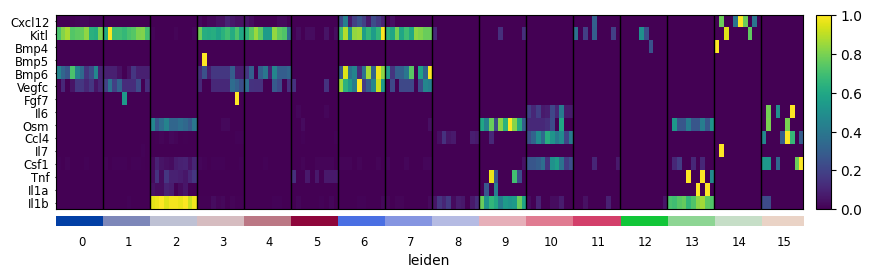

In [12]:
genes = [ "Cxcl12", "Kitl", "Cxcl14", "Bmp4","Bmp5", "Bmp6", "Vegfc", "Fgf7", "Ccl19", "Il6", "Osm", "Ccl4","Il7", "Csf1", "Csf2", "Csf3", "Tnf", "Il1a", "Il1b", "Ki67" ]
cluster_key = "leiden"

goi = [ g for g in genes if g in adata.var_names]

if len(goi) != len(genes):
    bad = [ g for g in genes if g not in adata.var_names]
    print(f"These genes could not be detected in the data: {bad}"   )

#cluster_key ="Chatties_celltypes"
pseudoclusters = functions.compute_cluster_mean_profiles_adata( adata[:, goi],cluster_key = cluster_key, random_state=10)
functions.summary_heatmap( pseudoclusters, cluster_key=cluster_key, experiment=experiment, save_path=f"New_List1_heatmap_{experiment}_{cluster_key}.svg" )

These genes could not be detected in the data: ['Pdgfra', 'Prrx', 'Col2a1', 'Acan', 'Bglap', 'Chd5', 'Pecan1']

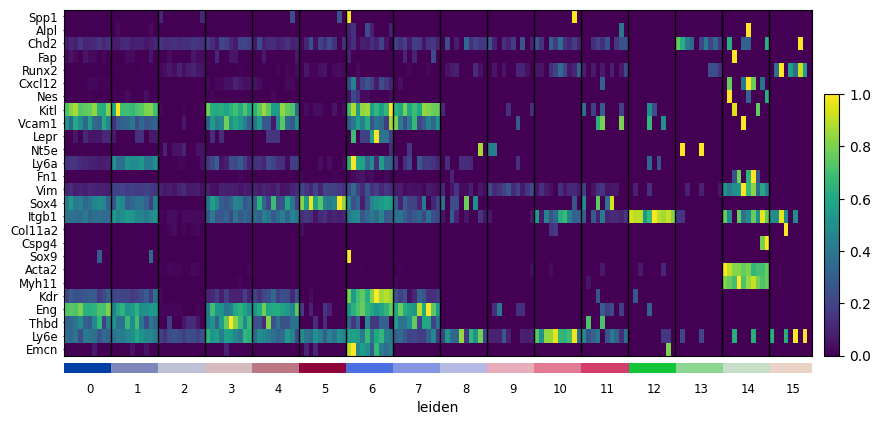

In [13]:
genes = [ "Spp1", "Alpl", "Chd2", "Fap", "Runx2", "Cxcl12", "Nes",  "Kitl", "Vcam1","Lepr", "Nt5e", "Ly6a", "Pdgfra", "Fn1", "Vim", "Sox4", "Prrx", "Itgb1", "Col2a1", 
        "Col11a2", "Acan", "Cspg4", "Sox9", "Bglap", "Acta2", "Myh11", "Kdr", "Eng", "Thbd", "Ly6e", "Chd5", "Emcn", "Pecan1"]
cluster_key = "leiden"

goi = [ g for g in genes if g in adata.var_names]

if len(goi) != len(genes):
    bad = [ g for g in genes if g not in adata.var_names]
    print(f"These genes could not be detected in the data: {bad}"   )

#cluster_key ="Chatties_celltypes"
pseudoclusters = functions.compute_cluster_mean_profiles_adata( adata[:, goi],cluster_key = cluster_key, random_state=10)
functions.summary_heatmap( pseudoclusters, cluster_key=cluster_key, experiment=experiment, save_path=f"New_List2_heatmap_{experiment}_{cluster_key}.svg" )